# 2040 le cap des 100% de voitures électriques 
*Etude data - Projet 8 - @Nalron (août 2020)*\
*Traitement des données sur Jupyter Notebook (Distribution Anaconda)*\
*Etude réalisée en langage Python*

Visualisation des Tableaux de bord: [Tableau Public](https://public.tableau.com/profile/nalron#!/vizhome/ElectricCarsFrance2040/Vuedensemble)

---

# Rappel des missions


### [Mission 1 : Positionnement de la voiture électrique en France](https://github.com/nalron/project_electric_cars_france2040/blob/french_version/p8_notebook01.ipynb)
Évolution du parc automobile électrique à 2 ans.<br>
Identification et classification des inégalités locales des voitures électriques.<br>
Autonomie et consommation moyenne d'une voiture électrique.

### [Mission 2 : Besoin des déploiements en IRVE](https://github.com/nalron/project_electric_cars_france2040/blob/french_version/p8_notebook02.ipynb)
Évolution du nombre de points de recharge disponibles ouverts au public.<br>
Analyse de la répartition par borne de recharge, type de prise et catégorie d’aménageur.<br>
Utilisation des ratios pour le dimensionnement d'un maillage de taille optimale.<br>
Prévision du nombre de PDC à horizon 2028.<br>

### [Mission 3 : Appel de charge au réseau électrique](https://github.com/nalron/project_electric_cars_france2040/blob/french_version/p8_notebook03.ipynb)
Analyse de la consommation d'électricité en France et des filières de production.<br>
Profiler un pic d’utilisation des bornes de recharge.<br>
Courbe de charge réseau électrique pour répondre aux nouveaux modes de consommation.

---

In [2]:
#Import des principales librairies Python
import pandas as pd
import plotly.figure_factory as ff
import requests
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.api import ExponentialSmoothing
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Mission 2 : Besoin des déploiements en IRVE<a id="borne">

__`Traitement des données sur les points de charge par typologie`__

Ce jeu de données présente le nombre total de points de charge en France continentale.

Les points de charge sont matérialisés par un socle de prise sur lequel un véhicule électrique peut potentiellement se brancher. Une borne de recharge peut comporter un ou plusieurs points de charge. Les données présentées segmentent les points de charge en trois typologies :

- Les points de charge « accessible au public » correspondent aux points de charge accessibles dans les commerces (supermarché, concession automobile…), parking, sites publics ou stations en voirie.
- Les points de charge « particulier » sont des points de charges privés localisés dans le résidentiel collectif (immeubles, copropriétés…) ou individuel (pavillons).
- Les points de charge « société » sont des points de charge privés localisés dans les sociétés et réservés à l’activité de la société ou à la recharge des véhicules électriques des employés.

Le jeu de données a été élaboré par Enedis à partir de ses données propres combinées avec certaines données externes, issues des sociétés Girève et AAA Data. Les données sur les points de charge « particulier » et « société » sont une reconstitution de l’existant construite par Enedis sur la base d’hypothèses. Ces hypothèses s’appuient sur l’évolution du marché du véhicule électrique.

In [173]:
#Chargement du jeu de données "nombre-de-points-de-charge-par-typologie.csv"
#https://www.data.gouv.fr/fr/datasets/nombre-de-points-de-charge-par-typologie/
#update 1 jannuary 2023
irve_type = pd.read_csv('../data/nombre-de-points-de-charge-par-typologie.csv', sep=';')
display(irve_type.shape)
display(irve_type.head())

(96, 5)

annee trimestre     mois             typologie  nombre
0   2022        T2  2022 T2           Particulier  575686
1   2021        T1  2021 T1  Accessible au public   37491
2   2021        T1  2021 T1           Particulier  307174
3   2019        T3  2019 T3               Société  125667
4   2018        T4  2018 T4  Accessible au public   26254

In [49]:
#Analyse des valeurs de la variable 'Nombre'
irve_type['nombre'].unique()

array([575686,  37491, 307174, 125667,  26254,  24319,  19750,  16220,
        48412,   8478,  25638,  34746, 688060, 515435,  43699, 307269,
       237863, 192823, 144123, 118974,  27516,  84921,  59408,  12859,
        43284,  32278,  38681,  29662, 180499, 135563,  29545, 123368,
        96616,  68509,  63757,  13861, 420774,  57732, 392504,  53667,
       359188, 269327, 222346, 172822, 115690,  22283,  78881,  17423,
       493648,  71630, 623836,  34686, 198437,  32648, 167797,  92537,
        73404,  55309,  48013,  82107, 465424, 402361, 331981,  31081,
        30203, 132275, 113101, 106839,  97164,  26325,  62957,  57039,
        37448,  10086, 446585,  64546, 368355, 267371,  33369,  86681,
        20688,  42891,  49086,  27668, 104895,  90950,  19309,  79807,
        73713,  68930,  52052,  52015,  12830,  11113,  10928,  37933])

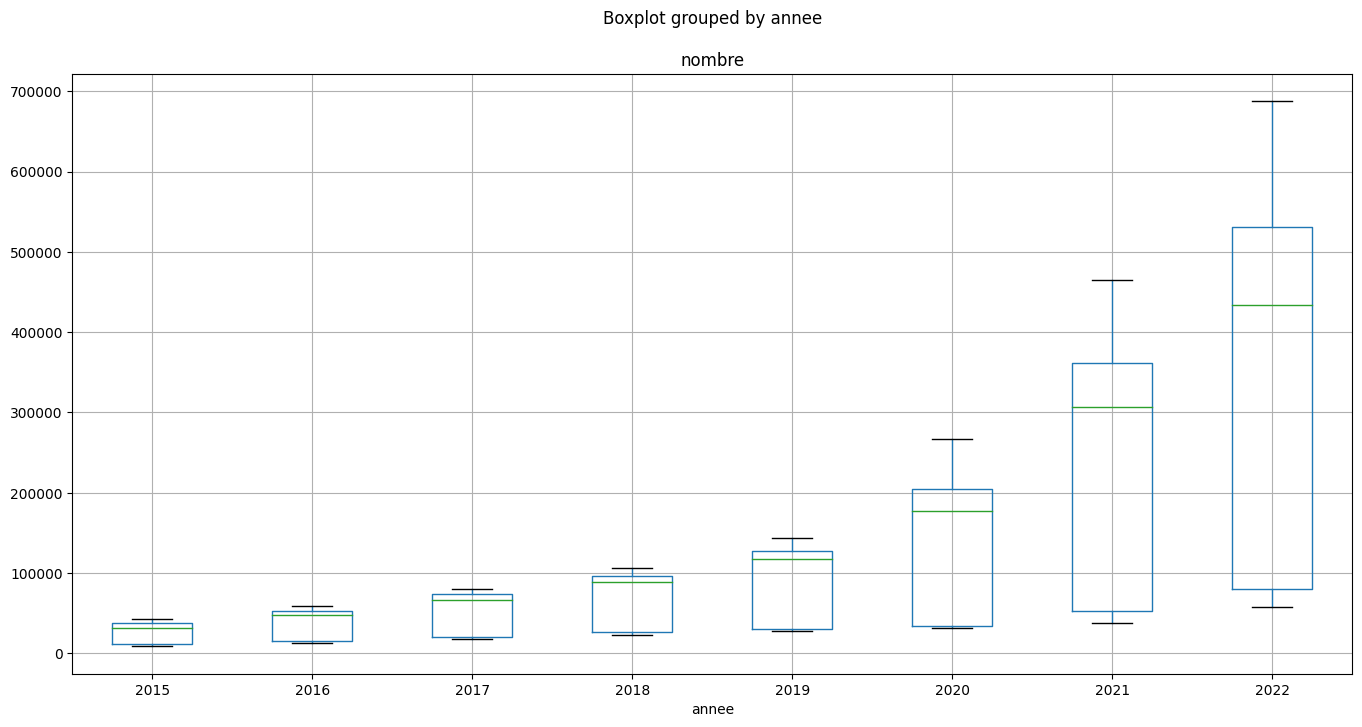

In [51]:
#plt.figure(figsize=(12,3))
irve_type.boxplot(column= 'nombre', by='annee')
plt.show()

Il ne semble pas avoir de valeur aberrante dans les valeurs de la variable 'Nombre'. Pour rappel, ici nous avons les points de charge électriques quantifiés par année et trimestre.

In [174]:
#Mise en forme plus logique des données selon l'année et le trimestre
irve_type = irve_type.pivot_table(index=['annee', 'trimestre'], 
                                  columns='typologie', 
                                  values='nombre').reset_index()
irve_type.columns.name = None
irve_type

annee trimestre  Accessible au public  Particulier  Société
0    2015        T1                  8478        25638    34746
1    2015        T2                 10086        29662    37933
2    2015        T3                 10928        32278    38681
3    2015        T4                 11113        37448    42891
4    2016        T1                 12830        43284    48013
5    2016        T2                 13861        48412    52015
6    2016        T3                 12859        52052    55309
7    2016        T4                 16220        57039    59408
8    2017        T1                 17423        62957    63757
9    2017        T2                 19750        68509    68930
10   2017        T3                 20688        73404    73713
11   2017        T4                 19309        79807    78881
12   2018        T1                 26325        86681    84921
13   2018        T2                 22283        92537    90950
14   2018        T3                 24319        97164    96616
15   2018        T4                 26254       106839   104895
16   2019        T1                 27516       115690   113101
17   2019        T2                 27668       123368   118974
18   2019        T3                 29545       132275   125667
19   2019        T4                 30203       144123   135563
20   2020        T1                 31081       172822   167797
21   2020        T2                 32648       192823   180499
22   2020        T3                 33369       222346   198437
23   2020        T4                 34686       267371   237863
24   2021        T1                 37491       307174   269327
25   2021        T2                 43699       359188   307269
26   2021        T3                 49086       402361   331981
27   2021        T4                 53667       465424   368355
28   2022        T1                 57732       515435   392504
29   2022        T2                 64546       575686   420774
30   2022        T3                 71630       623836   446585
31   2022        T4                 82107       688060   493648

In [175]:
#Calcul des évolutions en % entre chaque trimestre
for i, row in irve_type.iterrows():
    if i+1 < len(irve_type):
        number_public = ((irve_type.loc[i+1, 'Accessible au public'] 
                   - irve_type.loc[i, 'Accessible au public']) / (irve_type.loc[i, 'Accessible au public'])*100)
        irve_type.loc[i+1, '%Public'] = round(number_public, 2)
    if i+1 < len(irve_type):
        number_particulier = ((irve_type.loc[i+1, 'Particulier'] 
                   - irve_type.loc[i, 'Particulier']) / (irve_type.loc[i, 'Particulier'])*100)
        irve_type.loc[i+1, '%Particulier'] = round(number_particulier, 2)
    if i+1 < len(irve_type):
        number_societe = ((irve_type.loc[i+1, 'Société'] 
                   - irve_type.loc[i, 'Société']) / (irve_type.loc[i, 'Société'])*100)
        irve_type.loc[i+1, '%Société'] = round(number_societe, 2)
    else :
        irve_type.fillna(0, inplace=True)
        pass


In [176]:
#Modification des Trimestres pour obtenir un Time Series
irve_type.replace({'T1' : '31-03',
                    'T2' : '30-06',
                    'T3' : '30-09',
                    'T4' : '31-12'},
                   inplace=True)

irve_type['time'] = irve_type['annee'].astype(str)+ str("-")+irve_type['trimestre']
irve_type['time'] = pd.to_datetime(irve_type['time'], format="%Y-%d-%m")

In [177]:
#Affichage du dataframe enrichi
irve_type

annee trimestre  Accessible au public  Particulier  Société  %Public  \
0    2015     31-03                  8478        25638    34746     0.00   
1    2015     30-06                 10086        29662    37933    18.97   
2    2015     30-09                 10928        32278    38681     8.35   
3    2015     31-12                 11113        37448    42891     1.69   
4    2016     31-03                 12830        43284    48013    15.45   
5    2016     30-06                 13861        48412    52015     8.04   
6    2016     30-09                 12859        52052    55309    -7.23   
7    2016     31-12                 16220        57039    59408    26.14   
8    2017     31-03                 17423        62957    63757     7.42   
9    2017     30-06                 19750        68509    68930    13.36   
10   2017     30-09                 20688        73404    73713     4.75   
11   2017     31-12                 19309        79807    78881    -6.67   
12   2018     31-03                 26325        86681    84921    36.34   
13   2018     30-06                 22283        92537    90950   -15.35   
14   2018     30-09                 24319        97164    96616     9.14   
15   2018     31-12                 26254       106839   104895     7.96   
16   2019     31-03                 27516       115690   113101     4.81   
17   2019     30-06                 27668       123368   118974     0.55   
18   2019     30-09                 29545       132275   125667     6.78   
19   2019     31-12                 30203       144123   135563     2.23   
20   2020     31-03                 31081       172822   167797     2.91   
21   2020     30-06                 32648       192823   180499     5.04   
22   2020     30-09                 33369       222346   198437     2.21   
23   2020     31-12                 34686       267371   237863     3.95   
24   2021     31-03                 37491       307174   269327     8.09   
25   2021     30-06                 43699       359188   307269    16.56   
26   2021     30-09                 49086       402361   331981    12.33   
27   2021     31-12                 53667       465424   368355     9.33   
28   2022     31-03                 57732       515435   392504     7.57   
29   2022     30-06                 64546       575686   420774    11.80   
30   2022     30-09                 71630       623836   446585    10.98   
31   2022     31-12                 82107       688060   493648    14.63   

    %Particulier  %Société       time  
0           0.00      0.00 2015-03-31  
1          15.70      9.17 2015-06-30  
2           8.82      1.97 2015-09-30  
3          16.02     10.88 2015-12-31  
4          15.58     11.94 2016-03-31  
5          11.85      8.34 2016-06-30  
6           7.52      6.33 2016-09-30  
7           9.58      7.41 2016-12-31  
8          10.38      7.32 2017-03-31  
9           8.82      8.11 2017-06-30  
10          7.15      6.94 2017-09-30  
11          8.72      7.01 2017-12-31  
12          8.61      7.66 2018-03-31  
13          6.76      7.10 2018-06-30  
14          5.00      6.23 2018-09-30  
15          9.96      8.57 2018-12-31  
16          8.28      7.82 2019-03-31  
17          6.64      5.19 2019-06-30  
18          7.22      5.63 2019-09-30  
19          8.96      7.87 2019-12-31  
20         19.91     23.78 2020-03-31  
21         11.57      7.57 2020-06-30  
22         15.31      9.94 2020-09-30  
23         20.25     19.87 2020-12-31  
24         14.89     13.23 2021-03-31  
25         16.93     14.09 2021-06-30  
26         12.02      8.04 2021-09-30  
27         15.67     10.96 2021-12-31  
28         10.75      6.56 2022-03-31  
29         11.69      7.20 2022-06-30  
30          8.36      6.13 2022-09-30  
31         10.30     10.54 2022-12-31

In [178]:
#Affichage des types de données /Variables
irve_type.dtypes

annee                            int64
trimestre                       object
Accessible au public             int64
Particulier                      int64
Société                          int64
%Public                        float64
%Particulier                   float64
%Société                       float64
time                    datetime64[ns]
dtype: object

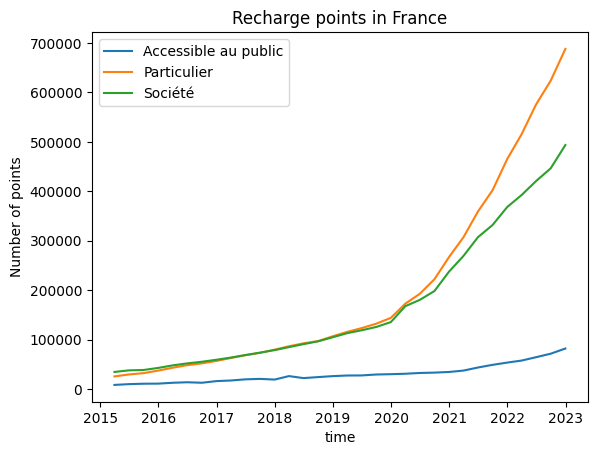

In [179]:
sns.lineplot(data=irve_type, x="time", y="Accessible au public", label="Accessible au public")
sns.lineplot(data=irve_type, x="time", y="Particulier",label="Particulier")
sns.lineplot(data=irve_type, x="time", y="Société",label="Société")
plt.title("Recharge points in France")
plt.ylabel("Number of points")
plt.legend()

In [66]:
#Analyse des valeurs manquantes du jeu de données 
irve_type.isna().any()

annee                   False
trimestre               False
Accessible au public    False
Particulier             False
Société                 False
%Public                 False
%Particulier            False
%Société                False
time                    False
dtype: bool

In [14]:
#Analyse des valeurs doublons du jeu de données 
irve_type.duplicated().any()

False

In [16]:
#Années traitées dans ce jeu de données list
list(irve_type['annee'].unique())

[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

In [65]:
#Sauvegarde 
irve_type.to_csv('../data/irve_type.csv')

__`Traitement des données sur les bornes de recharge pour vehicules electriques (IRVE)`__

Dans le but de constituer un répertoire national des Infrastructures de recharge pour véhicules électriques (IRVE), ouvert et accessible à tous, les collectivités locales porteuses d’un projet d’installation d’IRVE doivent, au fur et à mesure de la mise en service des stations, publier sur la plateforme data.gouv.fr les données statiques relatives à la localisation et aux caractéristiques techniques de ces installations selon les modalités définies dans l’arrêté du 4 mai 2021.
Etalab consolide l'ensemble des jeux de données produits par les différents acteurs territoriaux sur un jeu de donnée consolidé. Celui-ci a pour objectif d'être le plus exhaustif possible et ambitionne de regrouper l'ensemble des bornes IRVE françaises.


In [3]:
#Chargement du jeu de données "fichier-consolide-des-bornes-de-recharge-pour-vehicules-electriques-irve"
irve = pd.read_csv('../data/consolidation-etalab-schema-irve-statique-v-2.2.0-20230327.csv', 
                   sep=',', on_bad_lines='skip')
display(irve.shape)
display(irve.head())

(55320, 50)

nom_amenageur  siren_amenageur contact_amenageur nom_operateur  \
0       ELECTRA      891624884.0  help@electra.com       ELECTRA   
1       ELECTRA      891624884.0  help@electra.com       ELECTRA   
2       ELECTRA      891624884.0  help@electra.com       ELECTRA   
3       ELECTRA      891624884.0  help@electra.com       ELECTRA   
4       ELECTRA      891624884.0  help@electra.com       ELECTRA   

  contact_operateur telephone_operateur nom_enseigne id_station_itinerance  \
0  help@electra.com                 NaN      ELECTRA           FRELCPBLOHM   
1  help@electra.com                 NaN      ELECTRA           FRELCPECUSM   
2  help@electra.com                 NaN      ELECTRA           FRELCPSBARS   
3  help@electra.com                 NaN      ELECTRA           FRELCPSBARS   
4  help@electra.com                 NaN      ELECTRA           FRELCPSBARS   

  id_station_local                                       nom_station  ...  \
0              NaN  Blotzheim - Hôtel Mercure Bâle Mulhouse Aéroport  ...   
1              NaN                        Écully - Smart Lyon Écully  ...   
2              NaN                Saint-Barthélemy-d'Anjou - RS Parc  ...   
3              NaN                Saint-Barthélemy-d'Anjou - RS Parc  ...   
4              NaN                Saint-Barthélemy-d'Anjou - RS Parc  ...   

                      last_modified       datagouv_dataset_id  \
0  2023-03-28T05:05:10.757000+00:00  623ca46c13130c3228abd018   
1  2023-03-28T05:05:10.757000+00:00  623ca46c13130c3228abd018   
2  2023-03-28T05:05:10.757000+00:00  623ca46c13130c3228abd018   
3  2023-03-28T05:05:10.757000+00:00  623ca46c13130c3228abd018   
4  2023-03-28T05:05:10.757000+00:00  623ca46c13130c3228abd018   

                   datagouv_resource_id datagouv_organization_or_owner  \
0  a06bc4fc-f695-4ac6-ab81-562a30610fc2                        electra   
1  a06bc4fc-f695-4ac6-ab81-562a30610fc2                        electra   
2  a06bc4fc-f695-4ac6-ab81-562a30610fc2                        electra   
3  a06bc4fc-f695-4ac6-ab81-562a30610fc2                        electra   
4  a06bc4fc-f695-4ac6-ab81-562a30610fc2                        electra   

   consolidated_longitude consolidated_latitude consolidated_code_postal  \
0                7.502904             47.608214                  68730.0   
1                4.783111             45.785651                  69130.0   
2               -0.502617             47.481716                  49124.0   
3               -0.502617             47.481716                  49124.0   
4               -0.502617             47.481716                  49124.0   

       consolidated_commune consolidated_is_lon_lat_correct  \
0                 Blotzheim                            True   
1                    Écully                            True   
2  Saint-Barthélemy-d'Anjou                            True   
3  Saint-Barthélemy-d'Anjou                            True   
4  Saint-Barthélemy-d'Anjou                            True   

  consolidated_is_code_insee_verified  
0                                True  
1                                True  
2                                True  
3                                True  
4                                True  

[5 rows x 50 columns]

In [56]:
list(irve.nom_amenageur.unique())

['ELECTRA',
 'ARCACHON',
 'GARENNE',
 'FLEX-E',
 'GRAND NANCY',
 'MOBIVE - SDEER 17',
 'SIGEIF',
 'MOBIVE - TE 47',
 'CPS',
 'IZIVIA EXPRESS',
 'MOBIVE - SYDEC 40',
 'AVIA TD',
 'IZIVIA FMET 1',
 'UNIBAIL',
 'LEVAPARC',
 'MOBIVE - SEHV87',
 'OUEST CHARGE - 22',
 'WIIIZ',
 'SIXT',
 'MOBIVE - FDEE 19',
 'OUEST CHARGE - 29',
 'MOBIVE - SDEG 16',
 'MOBIVE - SDEPA 64',
 'OUEST CHARGE - 35',
 'SYDER',
 'AVIA PICOTY',
 'MOBIVE - SDE 24',
 'RT78',
 'MAMP',
 'SHELL',
 'ZENPARK',
 'SDESM',
 'GRSE GARAGE MARINIERE',
 'SCEA LES FUIES ',
 'SCEA LES FUIES',
 'STARTERRE',
 "LUMI'IN",
 'Hôtel Restaurant Campanile Nogent-sur-Marne',
 'Résidence Les Calanques',
 'Hotel saint Alban',
 '1PACTE',
 'Villa Primerose',
 'MAZDA CHALON S.SAONE - GROUPE GUILLET',
 'PAROT AUTOMOTIVE - MAZDA BRIVE ',
 'Aubade - Comptoir des Fers',
 'Aubade - Comptoir des Fer',
 'SCI LE PARC MILLESIME',
 'Suraya',
 'WeeCharge',
 'GCA CAEN ',
 'GCA CAEN',
 'Green Technologie',
 'MA BORNE AUTO',
 'DPA -MAZDA MONTELIMAR',
 'AUTO SPRIN

In [57]:
irve.isna().sum()

nom_amenageur                           3144
siren_amenageur                        14488
contact_amenageur                      14705
nom_operateur                           3624
contact_operateur                          0
telephone_operateur                     6860
nom_enseigne                               0
id_station_itinerance                      0
id_station_local                       26015
nom_station                                0
implantation_station                       0
adresse_station                            0
code_insee_commune                     16140
coordonneesXY                              0
nbre_pdc                                   0
id_pdc_itinerance                          0
id_pdc_local                           25927
puissance_nominale                         0
prise_type_ef                              0
prise_type_2                               0
prise_type_combo_ccs                       0
prise_type_chademo                         0
prise_type

Le premier point de contrôle passe par la recherche d'éventuels doublons. Notons que le contexte métier nécessite de la rigueur dans l'interprétation de certaines variables, l'amalgame entre station, borne et point de charge est régulièrement rencontré. Donc, "id_station" n'est pas le sous-ensemble le plus approprié à l'identification de doublons, une station de recharge peut avoir plusieurs points de charge, et l'identifiant ne tient pas compte du point de charge. Notons que "id_pdc_itinerance" permet d'obtenir des identifiants uniques pouvant cette fois-ci être pris comme sous-ensemble.

In [ ]:
#STRANGE!!!! SOME ID_PDC_ITINERANCE RESULT DUPLICATED BUT IS NOT TRUE----TO FIX

In [75]:
columns=irve.columns
for col in columns:
    duplicate_sum=irve[col].duplicated().sum()
    print(col, duplicate_sum)

nom_amenageur 52772
siren_amenageur 54134
contact_amenageur 54767
nom_operateur 55076
contact_operateur 55038
telephone_operateur 54953
nom_enseigne 53822
id_station_itinerance 36594
id_station_local 44396
nom_station 39770
implantation_station 55315
adresse_station 38728
code_insee_commune 50101
coordonneesXY 37997
nbre_pdc 55269
id_pdc_itinerance 11731
id_pdc_local 27253
puissance_nominale 55232
prise_type_ef 55312
prise_type_2 55312
prise_type_combo_ccs 55312
prise_type_chademo 55313
prise_type_autre 55313
gratuit 55311
paiement_acte 55312
paiement_cb 55312
paiement_autre 55311
tarification 55103
condition_acces 55318
reservation 55313
horaires 54751
accessibilite_pmr 55316
restriction_gabarit 55165
station_deux_roues 55314
raccordement 55317
num_pdl 52579
date_mise_en_service 53063
observations 55170
date_maj 54672
cable_t2_attache 55312
last_modified 54523
datagouv_dataset_id 54668
datagouv_resource_id 54523
datagouv_organization_or_owner 55111
consolidated_longitude 38090
consoli

In [81]:
irve.duplicated().sum()

0

In [92]:
irve.duplicated(subset="id_pdc_itinerance")


0        False
1        False
2        False
3        False
4        False
         ...  
55315    False
55316     True
55317     True
55318     True
55319     True
Length: 55320, dtype: bool

In [90]:
pd.set_option('display.max_columns', None)
irve.tail(10)

nom_amenageur  siren_amenageur              contact_amenageur  \
55310              CHARGEPOLY      850854993.0    info.request@chargepoly.com   
55311            EVE CAR PLUG      879689750.0         contact@evecarplug.com   
55312            EVE CAR PLUG      879689750.0         contact@evecarplug.com   
55313            EVE CAR PLUG      879689750.0         contact@evecarplug.com   
55314            EVE CAR PLUG      879689750.0         contact@evecarplug.com   
55315            EVE CAR PLUG      879689750.0         contact@evecarplug.com   
55316           MA Borne Auto      880217922.0        e.barre@maborneauto.com   
55317  Societe Ouest Location      323873174.0  Axel.peigne@ouest-location.fr   
55318  Societe Ouest Location      323873174.0  Axel.peigne@ouest-location.fr   
55319  Societe Ouest Location      323873174.0  Axel.peigne@ouest-location.fr   

       nom_operateur           contact_operateur telephone_operateur  \
55310     CHARGEPOLY     operator@chargepoly.com          0788984775   
55311     CHARGEPOLY     operator@chargepoly.com          0788984775   
55312     CHARGEPOLY     operator@chargepoly.com          0788984775   
55313     CHARGEPOLY     operator@chargepoly.com          0788984775   
55314     CHARGEPOLY     operator@chargepoly.com          0788984775   
55315     CHARGEPOLY     operator@chargepoly.com          0788984775   
55316  ma Borne Auto     e.barre@maborneauto.com          0361626161   
55317  Freshmile SAS  exploitation@freshmile.com           369246732   
55318  Freshmile SAS  exploitation@freshmile.com           369246732   
55319  Freshmile SAS  exploitation@freshmile.com           369246732   

      nom_enseigne              id_station_itinerance  \
55310   CHARGEPOLY    FRCHAPCKUIFU8QA0000JHPFD4KMPF72   
55311   CHARGEPOLY  FRCHAPCL667TZRR31386098QO29VPVB0N   
55312   CHARGEPOLY  FRCHAPCL667TZRR31386098QO29VPVB0N   
55313   CHARGEPOLY  FRCHAPCL667TZRR31386098QO29VPVB0N   
55314   CHARGEPOLY  FRCHAPCL667TZRR31386098QO29VPVB0N   
55315   CHARGEPOLY  FRCHAPCL667TZRR31386098QO29VPVB0N   
55316  DACIA RONCQ                       Non concerné   
55317    Freshmile                         FRFR1EGYTZ   
55318    Freshmile                         FRFR1EGYTZ   
55319    Freshmile                         FRFR1EGYTZ   

                  id_station_local                     nom_station  \
55310    ckuifu8qa0000jhpfd4kmpf72               Technopole Arbois   
55311  cl667tzrr31386098qo29vpvb0n               INDIAN MOTORCYCLE   
55312  cl667tzrr31386098qo29vpvb0n               INDIAN MOTORCYCLE   
55313  cl667tzrr31386098qo29vpvb0n               INDIAN MOTORCYCLE   
55314  cl667tzrr31386098qo29vpvb0n               INDIAN MOTORCYCLE   
55315  cl667tzrr31386098qo29vpvb0n               INDIAN MOTORCYCLE   
55316   01FHWQ8RECFE028717E5Y5123P                     DACIA RONCQ   
55317                          NaN  Ouest Location, Saint Herblain   
55318                          NaN  Ouest Location, Saint Herblain   
55319                          NaN  Ouest Location, Saint Herblain   

                      implantation_station  \
55310  Station dédiée à la recharge rapide   
55311  Station dédiée à la recharge rapide   
55312  Station dédiée à la recharge rapide   
55313  Station dédiée à la recharge rapide   
55314  Station dédiée à la recharge rapide   
55315  Station dédiée à la recharge rapide   
55316         Parking privé à usage public   
55317         Parking privé à usage public   
55318         Parking privé à usage public   
55319         Parking privé à usage public   

                                         adresse_station code_insee_commune  \
55310       Avenue Louis Philibert 13290 Aix-en-Provence              13001   
55311  27 Allée du Petit Puy 63170 Pérignat-lès-Sarliève              63108   
55312  27 Allée du Petit Puy 63170 Pérignat-lès-Sarliève              63108   
55313  27 Allée du Petit Puy 63170 Pérignat-lès-Sarliève              63108   
55314  27 Allée du Petit Puy 6

TO DISCUSS IF USE OTHER DATA OLD
Notons que le fichier mis à disposition sur le site data.gouv.fr annonce plusieurs consolidations selon les années 2014 à 2016 et 2018. Attention, quelques opérateurs comme Tesla, Nissan, Auchan, etc… ne sont plus observés dans la version de juin 2020 et même depuis plusieurs mois. Non pas parce que ces stations de recharge ont été retirées, mais par logique d'uniformisation selon une charte d'utilisation "Fichiers à destination des aménageurs et opérateurs publics et privés d'infrastructures de recharge pour véhicules électriques" consultable sur [data.gouv.fr](https://www.data.gouv.fr/fr/datasets/fichiers-pour-les-infrastructures-de-recharge-de-vehicules-electriques/)

<em>Le décret 2017-26 du 12 janvier 2017 fixe les exigences requises pour la configuration des points de recharge à publier sur un nouveau fichier désormais en CSV. L'aménageur, ou l'opérateur désigné le cas échéant, prend les mesures appropriées pour que ces données soient en permanence tenues à jour et rendues publiques sur data.gouv.fr</em>

<u>Dans le cadre de l'étude, les opérateurs (ou principaux opérateurs) identifiés comme manquants seront réintégrés dans l'échantillon.</u>

In [93]:
#Combien de stations de recharge (en anglais Charging Station Pool) à March 2023?
irve.id_station_itinerance.nunique()

18726

In [28]:
irve.id_station_local.nunique()

10923

In [94]:
#Combien de bornes de recharge (en anglais Charging Station) à March 2023?
irve.id_pdc_itinerance.nunique()

43589

Article trouve: 

85 284, c’est le nombre de points de recharge ouverts au public au 31 janvier 2023. Il est donc aujourd’hui de plus en plus facile de recharger sa voiture électrique. Il s’agit d’une évolution de + 57 % en un an. Si ces efforts se poursuivent, l’objectif pour la France d’atteindre les 100 000 points de recharge est ainsi facilement atteignable.

**Combien de points de charge (en anglais Charging Point ou EVSE) à Juin 2020?**
Selon la définition de l'AFIREV, le point de charge représente le nombre d'emplacement individuel permettant le stationnement du véhicule pendant le temps de charge, donc le nombre de prises de la borne. Le jeu de données `irve` ne permet pas de le quantifier directement, malgré la présence d'une variable 'nbre_pdc' qui ne représente que la borne et non le nombre de prises. Notons qu'il est nécessaire d'enrichir les données par une estimation des prises de chacune des bornes, ce calcul pourra être réalisé à l'aide de la variable 'type_prise'. <u>Cet enrichissement sera fait plus tard après intégration des opérateurs manquants.</u>

### Exploitation des opérateurs et aménageurs manquants

In [96]:
#Chargement du jeu de données de l'enseigne "Mobive"
#https://www.data.gouv.fr/fr/datasets/infrastructures-de-recharge-pour-vehicules-electriques-mobive-1/
mobive = pd.read_csv('p8_data/irve-mobivesdeer17-20230403.csv', sep=',', decimal=",", on_bad_lines='skip')
display(mobive.shape)
display(mobive.head())

(167, 39)

nom_amenageur  siren_amenageur            contact_amenageur  \
0  MOBIVE - SDEER 17        251702197  f-a.de-ferrieres@sdeer17.fr   
1  MOBIVE - SDEER 17        251702197  f-a.de-ferrieres@sdeer17.fr   
2  MOBIVE - SDEER 17        251702197  f-a.de-ferrieres@sdeer17.fr   
3  MOBIVE - SDEER 17        251702197  f-a.de-ferrieres@sdeer17.fr   
4  MOBIVE - SDEER 17        251702197  f-a.de-ferrieres@sdeer17.fr   

  nom_operateur contact_operateur  telephone_operateur       nom_enseigne  \
0        Izivia    sav@izivia.com            972668001  MOBIVE - SDEER 17   
1        Izivia    sav@izivia.com            972668001  MOBIVE - SDEER 17   
2        Izivia    sav@izivia.com            972668001  MOBIVE - SDEER 17   
3        Izivia    sav@izivia.com            972668001  MOBIVE - SDEER 17   
4        Izivia    sav@izivia.com            972668001  MOBIVE - SDEER 17   

  id_station_itinerance       id_station_local                  nom_station  \
0         FRS17PMB17112  FR*SOD*S*MB17*1*1*_*_     SAUJON - PLACE RICHELIEU   
1         FRS17PMB17111  FR*SOD*S*MB17*1*1*_*_     SAUJON - PLACE RICHELIEU   
2         FRS17PMB17112  FR*SOD*S*MB17*1*1*_*_     SAUJON - PLACE RICHELIEU   
3         FRS17PMB17212  FR*SOD*S*MB17*2*1*_*_  SURGERES - PLACE DU CHATEAU   
4         FRS17PMB17212  FR*SOD*S*MB17*2*1*_*_  SURGERES - PLACE DU CHATEAU   

  implantation_station   adresse_station  code_insee_commune  \
0               Voirie   PLACE RICHELIEU               17600   
1               Voirie   PLACE RICHELIEU               17600   
2               Voirie   PLACE RICHELIEU               17600   
3               Voirie  PLACE DU CHÂTEAU               17700   
4               Voirie  PLACE DU CHÂTEAU               17700   

           coordonneesXY  nbre_pdc id_pdc_itinerance           id_pdc_local  \
0  [45.676244,-0.925464]         2     FRS17EMB17112  FR*SOD*E*MB17*1*1*2*_   
1  [45.676244,-0.925464]         2     FRS17EMB17111  FR*SOD*E*MB17*1*1*1*_   
2  [45.676244,-0.925464]         2     FRS17EMB17112  FR*SOD*E*MB17*1*1*2*_   
3  [46.104744,-0.752427]         2     FRS17EMB17212  FR*SOD*E*MB17*2*1*2*_   
4  [46.104744,-0.752427]         2     FRS17EMB17212  FR*SOD*E*MB17*2*1*2*_   

   puissance_nominale  prise_type_ef  prise_type_2  prise_type_combo_ccs  \
0               50000          False         False                 False   
1               43000          False          True                 False   
2               50000          False         False                  True   
3               50000          False         False                 False   
4               50000          False         False                  True   

   prise_type_chademo  prise_type_autre  gratuit  paiement_acte  paiement_cb  \
0                True             False    False           True        False   
1               False             False    False           True        False   
2               False             False    False           True        False   
3                True             False    False           True        False   
4               False             False    False           True        False   

   paiement_autre  tarification condition_acces  reservation horaires  \
0            True           NaN     Accès libre        False     24/7   
1            True           NaN     Accès libre        False     24/7   
2            True           NaN     Accès libre        False     24/7   
3            True           NaN     Accès libre        False     24/7   
4            True           NaN     Accès libre        False     24/7   

        accessibilite_pmr restriction_gabarit  station_deux_roues  \
0  Accessibilité inconnue  Aucune Restriction               False   
1  Accessibilité inconnue  Aucune Restriction               False   
2  Accessibilité inconnue  Aucune Restriction               False   
3  Accessibilité inconnue  Aucune Restriction               False   
4  Accessibilité inconnue  Aucune Restriction               False 

In [97]:
irve[irve["id_pdc_itinerance"]=="FRS17EMB17112"]

nom_amenageur  siren_amenageur            contact_amenageur  \
656  MOBIVE - SDEER 17      251702197.0  f-a.de-ferrieres@sdeer17.fr   
657  MOBIVE - SDEER 17      251702197.0  f-a.de-ferrieres@sdeer17.fr   

    nom_operateur contact_operateur telephone_operateur       nom_enseigne  \
656        Izivia    sav@izivia.com          0972668001  MOBIVE - SDEER 17   
657        Izivia    sav@izivia.com          0972668001  MOBIVE - SDEER 17   

    id_station_itinerance       id_station_local               nom_station  \
656         FRS17PMB17112  FR*SOD*S*MB17*1*1*_*_  SAUJON - PLACE RICHELIEU   
657         FRS17PMB17112  FR*SOD*S*MB17*1*1*_*_  SAUJON - PLACE RICHELIEU   

    implantation_station  adresse_station code_insee_commune  \
656               Voirie  PLACE RICHELIEU              17421   
657               Voirie  PLACE RICHELIEU              17421   

              coordonneesXY  nbre_pdc id_pdc_itinerance  \
656  [-0.925464, 45.676244]         2     FRS17EMB17112   
657  [-0.925464, 45.676244]         2     FRS17EMB17112   

              id_pdc_local  puissance_nominale prise_type_ef prise_type_2  \
656  FR*SOD*E*MB17*1*1*2*_             50000.0         false        false   
657  FR*SOD*E*MB17*1*1*2*_             50000.0         false        false   

    prise_type_combo_ccs prise_type_chademo prise_type_autre gratuit  \
656                false               true            false   false   
657                 true              false            false   false   

    paiement_acte paiement_cb paiement_autre tarification condition_acces  \
656          true       false           true          NaN     Accès libre   
657          true       false           true          NaN     Accès libre   

    reservation horaires       accessibilite_pmr restriction_gabarit  \
656       false     24/7  Accessibilité inconnue  Aucune Restriction   
657       false     24/7  Accessibilité inconnue  Aucune Restriction   

    station_deux_roues raccordement num_pdl date_mise_en_service  \
656              false       Direct     NaN           2020-05-28   
657              false       Direct     NaN           2020-05-28   

                                          observations    date_maj  \
656  Conditions accès aux bornes dépendantes des ac...  2023-03-28   
657  Conditions accès aux bornes dépendantes des ac...  2023-03-28   

    cable_t2_attache                     last_modified  \
656              NaN  2023-03-28T02:52:25.427000+00:00   
657              NaN  2023-03-28T02:52:25.427000+00:00   

          datagouv_dataset_id                  datagouv_resource_id  \
656  6167e63c2dd57c81abe574e9  83f7eeca-6644-4e61-ab2a-0654f2948c2d   
657  6167e63c2dd57c81abe574e9  83f7eeca-6644-4e61-ab2a-0654f2948c2d   

    datagouv_organization_or_owner  consolidated_longitude  \
656                         izivia               -0.925464   
657                         izivia               -0.925464   

     consolidated_latitude  consolidated_code_postal consolidated_commune  \
656              45.676244                   17600.0               Saujon   
657              45.676244                   17600.0               Saujon   

     consolidated_is_lon_lat_correct  consolidated_is_code_insee_verified  
656                             True                                 True  
657                             True                                 True

In [44]:
#Test de matching des variables avant concaténation
display(irve.columns)
display(mobive.columns)

Index(['nom_amenageur', 'siren_amenageur', 'contact_amenageur',
       'nom_operateur', 'contact_operateur', 'telephone_operateur',
       'nom_enseigne', 'id_station_itinerance', 'id_station_local',
       'nom_station', 'implantation_station', 'adresse_station',
       'code_insee_commune', 'coordonneesXY', 'nbre_pdc', 'id_pdc_itinerance',
       'id_pdc_local', 'puissance_nominale', 'prise_type_ef', 'prise_type_2',
       'prise_type_combo_ccs', 'prise_type_chademo', 'prise_type_autre',
       'gratuit', 'paiement_acte', 'paiement_cb', 'paiement_autre',
       'tarification', 'condition_acces', 'reservation', 'horaires',
       'accessibilite_pmr', 'restriction_gabarit', 'station_deux_roues',
       'raccordement', 'num_pdl', 'date_mise_en_service', 'observations',
       'date_maj', 'cable_t2_attache', 'last_modified', 'datagouv_dataset_id',
       'datagouv_resource_id', 'datagouv_organization_or_owner',
       'consolidated_longitude', 'consolidated_latitude',
       'consolidate

Index(['nom_amenageur', 'siren_amenageur', 'contact_amenageur',
       'nom_operateur', 'contact_operateur', 'telephone_operateur',
       'nom_enseigne', 'id_station_itinerance', 'id_station_local',
       'nom_station', 'implantation_station', 'adresse_station',
       'code_insee_commune', 'coordonneesXY', 'nbre_pdc', 'id_pdc_itinerance',
       'id_pdc_local', 'puissance_nominale', 'prise_type_ef', 'prise_type_2',
       'prise_type_combo_ccs', 'prise_type_chademo', 'prise_type_autre',
       'gratuit', 'paiement_acte', 'paiement_cb', 'paiement_autre',
       'tarification', 'condition_acces', 'reservation', 'horaires',
       'accessibilite_pmr', 'restriction_gabarit', 'station_deux_roues',
       'raccordement', 'num_pdl', 'date_mise_en_service', 'observations',
       'date_maj'],
      dtype='object')

In [53]:
#consolidate latitude and longitude
mobive_tmp = pd.DataFrame()
mobive_tmp[['consolidated_longitude',"consolidated_latitude"]]=mobive['coordonneesXY'].str.split(",", expand = True)
mobive_tmp['consolidated_longitude']=mobive_tmp['consolidated_longitude'].str.replace('[','')
mobive_tmp["consolidated_latitude"]=mobive_tmp["consolidated_latitude"].str.replace(']','')
mobive = pd.concat([mobive, mobive_tmp], axis=1)
mobive['consolidated_longitude'] = mobive['consolidated_longitude'].astype(float)
mobive['consolidated_latitude'] = mobive['consolidated_latitude'].astype(float)
mobive.head()

/tmp/ipykernel_20835/3568744915.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  mobive_tmp['consolidated_longitude']=mobive_tmp['consolidated_longitude'].str.replace('[','')
/tmp/ipykernel_20835/3568744915.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  mobive_tmp["consolidated_latitude"]=mobive_tmp["consolidated_latitude"].str.replace(']','')


nom_amenageur  siren_amenageur            contact_amenageur  \
0  MOBIVE - SDEER 17        251702197  f-a.de-ferrieres@sdeer17.fr   
1  MOBIVE - SDEER 17        251702197  f-a.de-ferrieres@sdeer17.fr   
2  MOBIVE - SDEER 17        251702197  f-a.de-ferrieres@sdeer17.fr   
3  MOBIVE - SDEER 17        251702197  f-a.de-ferrieres@sdeer17.fr   
4  MOBIVE - SDEER 17        251702197  f-a.de-ferrieres@sdeer17.fr   

  nom_operateur contact_operateur  telephone_operateur       nom_enseigne  \
0        Izivia    sav@izivia.com            972668001  MOBIVE - SDEER 17   
1        Izivia    sav@izivia.com            972668001  MOBIVE - SDEER 17   
2        Izivia    sav@izivia.com            972668001  MOBIVE - SDEER 17   
3        Izivia    sav@izivia.com            972668001  MOBIVE - SDEER 17   
4        Izivia    sav@izivia.com            972668001  MOBIVE - SDEER 17   

  id_station_itinerance       id_station_local                  nom_station  \
0         FRS17PMB17112  FR*SOD*S*MB17*1*1*_*_     SAUJON - PLACE RICHELIEU   
1         FRS17PMB17111  FR*SOD*S*MB17*1*1*_*_     SAUJON - PLACE RICHELIEU   
2         FRS17PMB17112  FR*SOD*S*MB17*1*1*_*_     SAUJON - PLACE RICHELIEU   
3         FRS17PMB17212  FR*SOD*S*MB17*2*1*_*_  SURGERES - PLACE DU CHATEAU   
4         FRS17PMB17212  FR*SOD*S*MB17*2*1*_*_  SURGERES - PLACE DU CHATEAU   

   ... station_deux_roues raccordement  num_pdl date_mise_en_service  \
0  ...              False       Direct      NaN           2020-05-28   
1  ...              False       Direct      NaN           2020-05-28   
2  ...              False       Direct      NaN           2020-05-28   
3  ...              False       Direct      NaN           2020-05-28   
4  ...              False       Direct      NaN           2020-05-28   

                                        observations    date_maj  \
0  Conditions accès aux bornes dépendantes des ac...  2023-04-03   
1  Conditions accès aux bornes dépendantes des ac...  2023-04-03   
2  Conditions accès aux bornes dépendantes des ac...  2023-04-03   
3  Conditions accès aux bornes dépendantes des ac...  2023-04-03   
4  Conditions accès aux bornes dépendantes des ac...  2023-04-03   

   consolidated_longitude  consolidated_latitude  consolidated_longitude  \
0               45.676244              -0.925464               45.676244   
1               45.676244              -0.925464               45.676244   
2               45.676244              -0.925464               45.676244   
3               46.104744              -0.752427               46.104744   
4               46.104744              -0.752427               46.104744   

   consolidated_latitude  
0              -0.925464  
1              -0.925464  
2              -0.925464  
3              -0.752427  
4              -0.752427  

[5 rows x 43 columns]

#### Traitement NaN des variables n_amenageur, n_operateur et n_enseigne

In [99]:
#Traitement des NaN relatifs aux aménageurs selon l'enseigne
irve[irve['nom_amenageur'].isna()]['nom_enseigne'].unique()

array(['Ubitricity France Network', 'Hostellerie aux deux cléfs',
       'AREA Tech', 'ChargePoint', 'Camping la Belle Etoile',
       "MOULINS D'ASCQ", 'CLUB MED', 'GALILEO', 'MINI Panel Melun',
       'BMW Colmar', 'MINI Panel Auxerre', 'BMW MINI Panel Sens',
       'BMW REZÉ - Pays de Loire Automobiles',
       'BMW NANTES - Pays de Loire Automobiles',
       'Bmw Mini Saint-Herblain', 'Neviere',
       'Hyundai Valence - Valence Motors', 'FabreVolvo12850*1',
       'Bonne Anse Plage - Camping Siblu', 'DAF - GSVI MARSEILLE',
       'concessionnaire TOYOTA / NISSAN', 'Concessionnaire Kia',
       'HotelAKENA44000*1', 'Kia - MOTORS 76 Dieppe',
       'Hyundai Bruay-La-Buissière - Groupe Lempereur',
       'Concessionnaire Hyundai Sens', 'concessionnaire VOLVO',
       'Station Eurotyre', 'Camping 3 étoiles',
       'Volkswagen Véhicules Utilitaires', 'PANEL FONTAINEBLEAU Mini',
       'Volvo Tours (37) - Val de Loire Automobile',
       "Hyundai Lille Villeneuve-d'Ascq - V2 Automobile

In [151]:
'''#Boucle permettant le remplacement des valeurs manquantes des aménageurs selon condition
for i, row in irvePlus.iterrows():
    if row['n_enseigne'] == 'SIPLEC':
        irvePlus.loc[i, 'n_amenageur'] = 'LECLERC'      
    elif row['n_enseigne'] == 'EFFIA':
        irvePlus.loc[i, 'n_amenageur'] = 'EFFIA' 
    elif row['n_enseigne'] == 'Sodetrel':
        irvePlus.loc[i, 'n_amenageur'] = 'IZIVIA'
    elif row['n_enseigne'] == 'Concession NISSAN' or row['n_enseigne'] == 'NISSAN WEST EUROPE TRAINING' or row['n_enseigne'] == 'Siège NISSAN France':
        irvePlus.loc[i, 'n_amenageur'] = 'NISSAN'
    elif row['n_enseigne'] == 'Renault':
        irvePlus.loc[i, 'n_amenageur'] = 'RENAULT'   
    else :
        pass'''

In [103]:
#Traitement des NaN relatifs aux opérateurs selon l'aménageur
irve[irve['nom_operateur'].isna()]['nom_amenageur'].unique()

array(['GRAND NANCY', 'MOBIVE - SDEER 17', 'SIGEIF', 'MOBIVE - TE 47',
       'CPS', 'IZIVIA EXPRESS', 'MOBIVE - SYDEC 40', 'IZIVIA FMET 1',
       'UNIBAIL', 'MOBIVE - SEHV87', 'OUEST CHARGE - 22', 'WIIIZ',
       'MOBIVE - FDEE 19', 'OUEST CHARGE - 29', 'OUEST CHARGE - 35',
       'SYDER', 'ZENPARK', 'GRSE GARAGE MARINIERE', 'Indigo Propreté',
       'MOMATECH SARL - TECHOFFICE', 'BOIS CHERI - HOTEL DU PORGE',
       'HAPOGYS', 'LE  MOULIN DE LABOIRIE',
       "L'Hotelloise Hotel des Bains", 'ROBOTIC COVER CONCEPT', 'EPGML',
       'UCPA BOMBANNES', 'MOBIVE LA DIEGE', 'SEGA ELECTRICITE',
       'SCACHE GARAGE SENIA', nan, 'DE LEPERVANCHE Céline', 'TENTE SAS',
       'OVERCHEM', 'PHA', 'GAMBUS SARL', 'SERNAD INVESTISSEMENT',
       'METALLERIE PERRUT', 'MANUBOB', 'FLYOPS', 'NOVABIO', 'SARL RUITER',
       'GAZ DE BORDEAUX', '4M RETAIL', "L'AERODROME DE LA BAIE DE SOMME",
       'MOBIVE - SDEEG 33'], dtype=object)

In [102]:
#Boucle permettant le remplacement des valeurs manquantes des aménageurs selon condition
for i, row in irve.iterrows():
    if row['nom_amenageur'] == 'LECLERC':
        irve.loc[i, 'nom_operateur'] = 'LECLERC'
    elif row['nom_amenageur'] == 'AUCHAN  ':
        irve.loc[i, 'nom_operateur'] = 'AUCHAN'
    elif row['nom_amenageur'] == 'EFFIA':
        irve.loc[i, 'nom_operateur'] = 'EFFIA'
    elif row['nom_amenageur'] == 'IZIVIA':
        irve.loc[i, 'nom_operateur'] = 'IZIVIA' 
    elif row['nom_amenageur'] == 'NISSAN':
        irve.loc[i, 'nom_operateur'] = 'NISSAN'
    elif row['nom_amenageur'] == 'RENAULT':
        irve.loc[i, 'nom_operateur'] = 'RENAULT'  
    else :
        pass

In [105]:
#Traitement des NaN relatifs aux enseignes selon l'opérateur
irve[irve['nom_enseigne'].isna()]['nom_operateur'].unique()

array([], dtype=object)

In [155]:
'''
#Boucle permettant le remplacement des valeurs manquantes des enseignes selon condition
for i, row in irvePlus.iterrows():
    if row['n_operateur'] == 'CITEOS/FRESHMILE':
        irvePlus.loc[i, 'n_enseigne'] = 'Scame'
    elif row['n_operateur'] == 'New motion':
        irvePlus.loc[i, 'n_enseigne'] = 'New motion'
    elif row['n_operateur'] == 'MOUVELECVAR':
        irvePlus.loc[i, 'n_enseigne'] = 'MOUVELECVAR'
    elif row['n_operateur'] == 'SAINT-LOUIS':
        irvePlus.loc[i, 'n_enseigne'] = 'SAINT-LOUIS' 
    elif row['n_operateur'] == 'SPIE':
        irvePlus.loc[i, 'n_enseigne'] = 'SDEY'
    elif row['n_operateur'] == 'AUCHAN':
        irvePlus.loc[i, 'n_enseigne'] = 'AUCHAN'  
    else :
        pass'''

#### Traitement NaN des variables Xlongitude et Ylatitude

In [107]:
irve.columns

Index(['nom_amenageur', 'siren_amenageur', 'contact_amenageur',
       'nom_operateur', 'contact_operateur', 'telephone_operateur',
       'nom_enseigne', 'id_station_itinerance', 'id_station_local',
       'nom_station', 'implantation_station', 'adresse_station',
       'code_insee_commune', 'coordonneesXY', 'nbre_pdc', 'id_pdc_itinerance',
       'id_pdc_local', 'puissance_nominale', 'prise_type_ef', 'prise_type_2',
       'prise_type_combo_ccs', 'prise_type_chademo', 'prise_type_autre',
       'gratuit', 'paiement_acte', 'paiement_cb', 'paiement_autre',
       'tarification', 'condition_acces', 'reservation', 'horaires',
       'accessibilite_pmr', 'restriction_gabarit', 'station_deux_roues',
       'raccordement', 'num_pdl', 'date_mise_en_service', 'observations',
       'date_maj', 'cable_t2_attache', 'last_modified', 'datagouv_dataset_id',
       'datagouv_resource_id', 'datagouv_organization_or_owner',
       'consolidated_longitude', 'consolidated_latitude',
       'consolidate

In [109]:
#Traitement des deux NaN 'Xlongitude' et 'Ylatitude'
irve[irve['consolidated_latitude'].isna()]

Empty DataFrame
Columns: [nom_amenageur, siren_amenageur, contact_amenageur, nom_operateur, contact_operateur, telephone_operateur, nom_enseigne, id_station_itinerance, id_station_local, nom_station, implantation_station, adresse_station, code_insee_commune, coordonneesXY, nbre_pdc, id_pdc_itinerance, id_pdc_local, puissance_nominale, prise_type_ef, prise_type_2, prise_type_combo_ccs, prise_type_chademo, prise_type_autre, gratuit, paiement_acte, paiement_cb, paiement_autre, tarification, condition_acces, reservation, horaires, accessibilite_pmr, restriction_gabarit, station_deux_roues, raccordement, num_pdl, date_mise_en_service, observations, date_maj, cable_t2_attache, last_modified, datagouv_dataset_id, datagouv_resource_id, datagouv_organization_or_owner, consolidated_longitude, consolidated_latitude, consolidated_code_postal, consolidated_commune, consolidated_is_lon_lat_correct, consolidated_is_code_insee_verified]
Index: []

#### Traitement NaN de la variable 'type_prise'

In [142]:
prises=["prise_type_ef","prise_type_2","prise_type_combo_ccs","prise_type_chademo","prise_type_autre"]
for prise in prises:
    print(prise, irve[prise].unique())

prise_type_ef ['false' 'true' '0' 'FALSE' 'TRUE' '1' 'True' 'False']
prise_type_2 ['false' 'true' '1' '0' 'TRUE' 'FALSE' 'True' 'False']
prise_type_combo_ccs ['true' 'false' '1' 'FALSE' '0' 'TRUE' 'False' 'True']
prise_type_chademo ['false' 'true' '0' 'FALSE' 'TRUE' 'False' 'True']
prise_type_autre ['false' 'true' '0' 'FALSE' 'TRUE' 'False' 'True']


In [4]:
#creation of column type_prise

irve.loc[irve["prise_type_ef"].str.lower()=="true","prise_type_ef"]=1
irve.loc[irve["prise_type_ef"].str.lower()=="false","prise_type_ef"]=0
irve.loc[irve["prise_type_2"].str.lower()=="true","prise_type_2"]=1
irve.loc[irve["prise_type_2"].str.lower()=="false","prise_type_2"]=0
irve.loc[irve["prise_type_combo_ccs"].str.lower()=="true","prise_type_combo_ccs"]=1
irve.loc[irve["prise_type_combo_ccs"].str.lower()=="false","prise_type_combo_ccs"]=0
irve.loc[irve["prise_type_autre"].str.lower()=="true","prise_type_autre"]=1
irve.loc[irve["prise_type_autre"].str.lower()=="false","prise_type_autre"]=0
irve.loc[irve["prise_type_chademo"].str.lower()=="true","prise_type_chademo"]=1
irve.loc[irve["prise_type_chademo"].str.lower()=="false","prise_type_chademo"]=0

irve["prise_type_ef"]=irve["prise_type_ef"].astype(int)
irve["prise_type_2"]=irve["prise_type_2"].astype(int)
irve["prise_type_combo_ccs"]=irve["prise_type_combo_ccs"].astype(int)
irve["prise_type_autre"]=irve["prise_type_autre"].astype(int)
irve["prise_type_chademo"]=irve["prise_type_chademo"].astype(int)


irve

nom_amenageur  siren_amenageur              contact_amenageur  \
0                     ELECTRA      891624884.0               help@electra.com   
1                     ELECTRA      891624884.0               help@electra.com   
2                     ELECTRA      891624884.0               help@electra.com   
3                     ELECTRA      891624884.0               help@electra.com   
4                     ELECTRA      891624884.0               help@electra.com   
...                       ...              ...                            ...   
55315            EVE CAR PLUG      879689750.0         contact@evecarplug.com   
55316           MA Borne Auto      880217922.0        e.barre@maborneauto.com   
55317  Societe Ouest Location      323873174.0  Axel.peigne@ouest-location.fr   
55318  Societe Ouest Location      323873174.0  Axel.peigne@ouest-location.fr   
55319  Societe Ouest Location      323873174.0  Axel.peigne@ouest-location.fr   

       nom_operateur           contact_operateur telephone_operateur  \
0            ELECTRA            help@electra.com                 NaN   
1            ELECTRA            help@electra.com                 NaN   
2            ELECTRA            help@electra.com                 NaN   
3            ELECTRA            help@electra.com                 NaN   
4            ELECTRA            help@electra.com                 NaN   
...              ...                         ...                 ...   
55315     CHARGEPOLY     operator@chargepoly.com          0788984775   
55316  ma Borne Auto     e.barre@maborneauto.com          0361626161   
55317  Freshmile SAS  exploitation@freshmile.com           369246732   
55318  Freshmile SAS  exploitation@freshmile.com           369246732   
55319  Freshmile SAS  exploitation@freshmile.com           369246732   

      nom_enseigne              id_station_itinerance  \
0          ELECTRA                        FRELCPBLOHM   
1          ELECTRA                        FRELCPECUSM   
2          ELECTRA                        FRELCPSBARS   
3          ELECTRA                        FRELCPSBARS   
4          ELECTRA                        FRELCPSBARS   
...            ...                                ...   
55315   CHARGEPOLY  FRCHAPCL667TZRR31386098QO29VPVB0N   
55316  DACIA RONCQ                       Non concerné   
55317    Freshmile                         FRFR1EGYTZ   
55318    Freshmile                         FRFR1EGYTZ   
55319    Freshmile                         FRFR1EGYTZ   

                  id_station_local  \
0                              NaN   
1                              NaN   
2                              NaN   
3                              NaN   
4                              NaN   
...                            ...   
55315  cl667tzrr31386098qo29vpvb0n   
55316   01FHWQ8RECFE028717E5Y5123P   
55317                          NaN   
55318                          NaN   
55319                          NaN   

                                            nom_station  ...  \
0      Blotzheim - Hôtel Mercure Bâle Mulhouse Aéroport  ...   
1                            Écully - Smart Lyon Écully  ...   
2                    Saint-Barthélemy-d'Anjou - RS Parc  ...   
3                    Saint-Barthélemy-d'Anjou - RS Parc  ...   
4                    Saint-Barthélemy-d'Anjou - RS Parc  ...   
...                                                 ...  ...   
55315                                 INDIAN MOTORCYCLE  ...   
55316                                       DACIA RONCQ  ...   
55317                    Ouest Location, Saint Herblain  ...   
55318                    Ouest Location, Saint Herblain  ...   
55319                    Ouest Location, Saint Herblain  ...   

                          last_modified       datagouv_dataset_id  \
0      2023-03-28T05:05:10.757000+00:00  623ca46c13130c3228abd018   
1      2023-03-28T05:05:10.757000+00:00  623ca46c13130c3228abd018   
2      2023-03-28T05:05:10.757000+00:00  623ca46c13130c3228a

In [5]:
prises=["prise_type_ef","prise_type_2","prise_type_combo_ccs","prise_type_chademo","prise_type_autre"]
for prise in prises:
    print(prise, irve[prise].unique())

prise_type_ef [0 1]
prise_type_2 [0 1]
prise_type_combo_ccs [1 0]
prise_type_chademo [0 1]
prise_type_autre [0 1]


prise_type  count
0         prise_type_ef  35373
1          prise_type_2  43879
2  prise_type_combo_ccs   9375
3    prise_type_chademo   2929
4      prise_type_autre   3325

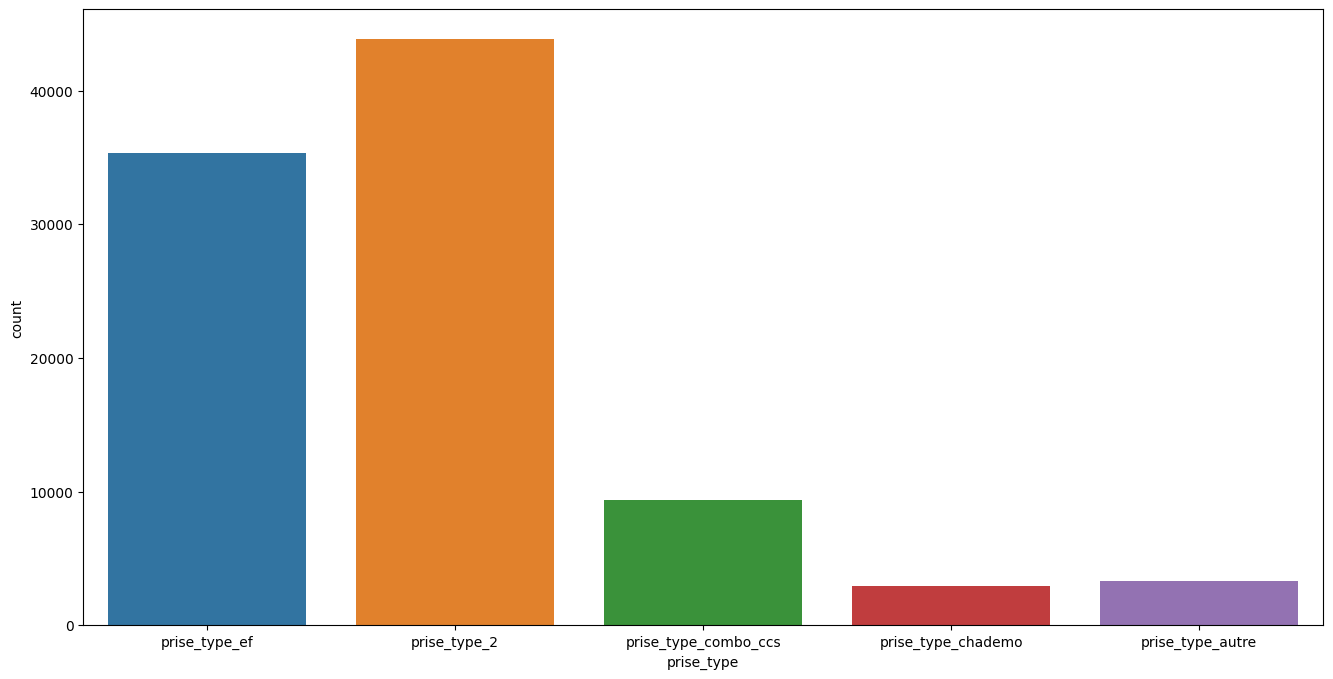

In [195]:
#test1=pd.DataFrame([irve["prise_type_ef"].sum()], columns=["bo"])
prises_list=[["prise_type_ef",irve["prise_type_ef"].sum()],["prise_type_2",irve["prise_type_2"].sum()],["prise_type_combo_ccs",irve["prise_type_combo_ccs"].sum()],["prise_type_chademo",irve["prise_type_chademo"].sum()],["prise_type_autre",irve["prise_type_autre"].sum()]]
prises_df_count=pd.DataFrame(prises_list, columns=["prise_type","count"])
sns.barplot(data=prises_df_count, x="prise_type", y="count", label=True)
prises_df_count

Globalement le groupe Auchan à équipé ses parkings de bornes Type 2 + CHAdeMO, notons que l'échantillon sera donc complété selon cette hypothèse, hypothèse retenue et préférable devant les NaN.

#### Traitement NaN de la variable 'puiss_max'

L'enrichissement de l'échantillon de départ `irve` rend l'exploitation de la variable 'id_pdc' obsolète. En effet, la concaténation avec les autres sources de données permet un recensement plus complet du réseau, mais sans pouvoir obtenir une charte d'utilisation commune et complète. En l'occurrence les id des points de charge ne sont plus complets, notons donc qu'il est nécessaire d'intégrer un identifiant unique à cet usage.

In [163]:
#Intégration d'un identifiant unique par Point de charge
irvePlus['id_borne']= np.arange(1, len(irvePlus)+1)

Il n'est pas nécessaire de traiter toutes les valeurs NaN, dans le contexte de l'étude les précédents traitements semblent être suffisants. Voyons immédiatement comment enrichir et optimiser ce qui peut l'être, comme par exemple les puissances et les types de prise.

#### Traitement à des fins d'uniformisation des modalités  de la variable 'type_prise'

#### Traitement des valeurs manquantes identifiées dans le comptage des points de charge

In [15]:
irve.columns

Index(['nom_amenageur', 'siren_amenageur', 'contact_amenageur',
       'nom_operateur', 'contact_operateur', 'telephone_operateur',
       'nom_enseigne', 'id_station_itinerance', 'id_station_local',
       'nom_station', 'implantation_station', 'adresse_station',
       'code_insee_commune', 'coordonneesXY', 'nbre_pdc', 'id_pdc_itinerance',
       'id_pdc_local', 'puissance_nominale', 'prise_type_ef', 'prise_type_2',
       'prise_type_combo_ccs', 'prise_type_chademo', 'prise_type_autre',
       'gratuit', 'paiement_acte', 'paiement_cb', 'paiement_autre',
       'tarification', 'condition_acces', 'reservation', 'horaires',
       'accessibilite_pmr', 'restriction_gabarit', 'station_deux_roues',
       'raccordement', 'num_pdl', 'date_mise_en_service', 'observations',
       'date_maj', 'cable_t2_attache', 'last_modified', 'datagouv_dataset_id',
       'datagouv_resource_id', 'datagouv_organization_or_owner',
       'consolidated_longitude', 'consolidated_latitude',
       'consolidate

In [16]:
#Identification des aménageurs concernés par le nombre de pdc manquant
irve[irve.nbre_pdc.isna()]['nom_amenageur'].unique()

array([], dtype=object)

#### Enrichissement de l'échantillon en intégrant une catégorisation des aménageurs 
Cette étape permettra de pouvoir obtenir une vision plus explicite de qui sont les aménageurs IRVE sur notre territoire. Il semble pertinent de pouvoir mieux comprendre comment s'organise l'implantation des bornes.

In [17]:
#Aperçu de la diversité des aménageurs à l'origine de l'implantation des bornes en France
irve.nom_amenageur.unique()[:30]

array(['ELECTRA', 'ARCACHON', 'GARENNE', 'FLEX-E', 'GRAND NANCY',
       'MOBIVE - SDEER 17', 'SIGEIF', 'MOBIVE - TE 47', 'CPS',
       'IZIVIA EXPRESS', 'MOBIVE - SYDEC 40', 'AVIA TD', 'IZIVIA FMET 1',
       'UNIBAIL', 'LEVAPARC', 'MOBIVE - SEHV87', 'OUEST CHARGE - 22',
       'WIIIZ', 'SIXT', 'MOBIVE - FDEE 19', 'OUEST CHARGE - 29',
       'MOBIVE - SDEG 16', 'MOBIVE - SDEPA 64', 'OUEST CHARGE - 35',
       'SYDER', 'AVIA PICOTY', 'MOBIVE - SDE 24', 'RT78', 'MAMP', 'SHELL'],
      dtype=object)

In [46]:
#Liste des catégories pouvant rassembler les aménageurs identifiées dans l'échantillon

#Collectivités territoriales
list_c_t = ['Aix-Marseille-Provence', 'BREST METROPOLE', 'CAPG', 'CAPL', 'CARF', 'CC VITRY CHAMPAGNE ET DER', 
 'CC de la Côtičre', 'CCPA', 'CCPHVA', 'CCVBA', 'CELLIEU', 'CGLE', 'CHARLIEU','CHAUSSON MATERIAUX', 
 'CHAZELLES SUR LYON', 'CNR', 'COMMELLE VERNAY',"Communauté Urbaine d'Arras", 'CANTAL', 'Aéroports de Paris SA', 
 "Communauté d'Agglomération Douaisis Agglo","Communauté d'Agglomération Maubeuge Val de Sambre", 'SODETREL ',
 "Communauté d'Agglomération Valenciennes Métropole", "Communauté d'Agglomération du Boulonnais", 'SMOYS', 
 "Communauté d'Agglomération du Pays de Saint Omer", 'Communauté de Communes Flandre-Lys', 'SMEG 30', 
 'Communauté de Communes de la Haute Vallée de Chevreuse', "Communauté de Communes du Coeur d'Ostrevent",
 'Communauté de Communes du Haut-Pays Montreuillois', "Communauté de Communes du Pays d'Opale",
 'Communauté de Communes du Pays de Lumbres', "Commune d'Eguisheim",'FDEL 46', 'FDEL 46', 'FEURS',
 'FONTANÈS', 'FRAISSES', 'GENILAC', 'GOLF CLUB DE LYON', 'GPSO-MEUDON', 'Grenoble-Alpes Métropole', 
 'Hauts-de-France', 'Herault Energies 34', 'ISTRES', "L'ETRAT", "L'HORME", 'LA FOUILLOUSE', 'LA GRAND CROIX', 
 'LA PACAUDIÈRE', 'LA RICAMARIE', 'LA TALAUDIÈRE', 'LA VALLA EN GIER', 'LE COTEAU', 'LORETTE','Le Pont du Gard', 
 'MABLY', 'MARLHES', 'MONTAGNY', 'MONTBRISON', 'MOUVELECVAR', 'MRN', 'Modulo (Mobilité Locale Durable)',
 'Montpellier Mediterranee Metropole', 'Métropole Européenne de Lille', 'NEULISE', 'ORLEANS METROPOLE',
 'PANISSIERES', 'PARIGNY', 'PERREUX','REGNY', 'RENAISON', 'RIORGES', 'ROANNE', 'ROCHE LA MOLIÈRE',
 'SABLE SUR SARTHE', "SAINT ANDRÉ D'APCHON", 'SAINT ANDRÉ LE PUY', 'SAINT BONNET LE CHÂTEAU', 
 'SAINT CHRISTO EN JAREZ', 'SAINT CYR', 'SAINT ETIENNE ROCHETAILLÉE', 'SAINT ETIENNE SAINT VICTOR SUR LOIRE', 
 'SAINT GALMIER', 'SAINT GENEST LERPT', 'SAINT HÉAND', 'SAINT JUST SAINT RAMBERT', 'SAINT LÉGER SUR ROANNE', 
 'SAINT MARCELLIN EN FOREZ', 'SAINT MARTIN LA PLAINE', 'SAINT MAURICE EN GOURGOIS', 'SAINT PAUL EN JAREZ', 
 'SAINT ROMAIN EN JAREZ', 'SAINT ROMAIN LES ATHEUX', 'SAINT SAUVEUR EN RUE', 'SAINT SYMPHORIEN DE LAY', 'SAINT-LOUIS', 'SAINTE CROIX EN JAREZ', 
 'SALVIZINET', 'SAVIGNEUX', 'SDE 18', 'SDE 23', 'SDE 56', 'SDE 65', 'SDE07', 'SDE09', 'SDE29', 'SDE65', 'SDE76', 
 'SDEA10', 'SDED', 'SDEE48 48', 'SDESM', 'SDET 81', 'SDEY', "SDEY Syndicat Departemental d'Energies de l'Yonne", 
 'SE60', 'SEDI', 'SIDELC', 'SIED70', 'SIEDA 12', 'SIEEEN', 'SIEGE 27', 'SIEIL37', 'SIEML 49', 'SIPPEREC', 
 'SMA PNR Gatinais', 'SMED 13', 'SORBIERS', 'SOREGIES', 'SURY LE COMTAL', 'SYADEN 11', 'SYANE', 'SYDED', 
 'SYDEEL66 66', 'SYDESL', 'SYDEV 85', 'SYME05', 'Se 61', 'TE 53', "TERRITOIRE D'ENERGIE 90", 'Séolis', 'S‚olis',
 "Syndicat Départemental d'Énergie de Loire-Atlantique (SYDELA)", 'FDEE 19', 'SDEPA 64', 'SDEG 16', 
 "Syndicat Départemental d'Énergies d'Eure et Loir (SDE28)", 'SDEE 47', 'SDEER 17', 'SYDEC 40',
 "Syndicat Intercommunal de Distribution d'Electricité de Loir-et-Cher (SIDELC41)", 'SDE 24', 'SDEEG 33',
 "Syndicat de l'Énergie de l'Orne (TE61)", 'Toulouse Metropole', 'UNIEUX', 'USEDA', 'USSON EN FOREZ',
 'VEAUCHE', 'VILLARS', 'VILLE DE CAVAILLON', 'VILLE DE GAP', 'VILLE DE ROSHEIM', 'VILLEREST', "Ville d'Hazebrouck",
 'Ville de Garches', 'Ville de Montrouge', 'Ville de Revel', 'Ville de Saverne', 'Ville de Viriat', 
 'Arcs 1950 Le Village - Parking', 'B&B Hôtel Lyon Eurexpo Chassieu', "Bastide Selva - Maison d'Hôtes",
 'Baumanière les Baux de Provence', 'Belle Isle sur Risle','Benvengudo Hôtel Restaurant', 
 'Best Western Amarys Rambouillet', 'Best Western Golf Hôtel Lacanau','Best Western Grand Hôtel de Bordeaux',
 'Best Western Hotel Alexandra', 'Best Western le Lavarin', 'Best Western Plus - Hôtel de la Paix',
 'Best Western Plus - Hôtel de la Régate', 'Best Western Plus Cannes Riviera & spa',
 'Best Western Plus Excelsior Chamonix', 'Best Western Plus Santa Maria', 'Brasserie des Eclusiers',
 'Buffalo Grill de Foix', 'Caffe Mazzo', 'Camping BelleRive', 'Camping du Domaine de Massereau', 
 "Camping Ecolodge de l'Etoile d'Argens", 'Camping La Fontaine du Hallate en Morbihan', "Camping La Roche d'Ully", 
 'Camping Le Brasilia', 'Camping Palmira Beach', 'Camping Sunêlia Berrua', 'Camping Sunêlia Le Fief *****', 
 "Casino d'Évian - Evian Resort", "Casino d'Andernos - Le Miami", 'Casino De Plombières-Les-Bains',
 'Casino de Pornichet', 'Casino Joa Antibes La Siesta', 'Casino JOA Le Boulou', 'Casino Le Domaine de Forges',
 'Casino Partouche de Boulogne-sur-Mer', 'Casino Partouche de Palavas Les FLots','Castel Camping Le Brévedent', 
 'Castel Maintenon']

#Constructeurs Auto
list_auto = ['IONITY', 'Tesla', 'A Cheda', 'NISSAN', 'RENAULT','BMW Châlons-en-Champagne',
 'BMW Cherbourg-en-Cotentin',
 'BMW Charleville-Mézières',
 'BMW Compiègne',
 'BMW Distribution - Vélizy public',
"BMW-MINI Flers de l'Orne",
 'BMW Nogent la Phaye',
 'BMW Namur',
 'BMW Mini - Station 7',
 'BMW Mareuil-les-Meaux',
 'BMW Magny-Cours public',
 'BMW Granville',
 'BMW, Dreux',
 'BMW Puilboreau',
 'BMW Soissons',
 'BMW Saint-Quentin',
 'BMW Saint Lô',
 'BMW Reims']

#Parkings 
list_parking = ['EFFIA', 'Alyse Parc Auto', 'Parking Bodin', 'Parking François 1er Interparking', 'TM _Parking']

#Centres commerciaux
list_centres_commerciaux = ['Centre commercial Grand Var', 'GEMO', 'Sičge Intermarché', 'Supermarchés COLRUYT', 'LECLERC', 'AUCHAN  ', 'LECLERC',
 'Centre Commercial Carrefour Villiers en Bière', 'Centre commercial Les Eléis', 'Centre Commercial Parly 2',
 'Centre Commercial Waves Actisud', 'E-Leclerc Paray-le-Monial', 'Hyper U Sierentz', "Intermarché l'Isle sur le Doubs",
 'Intermarché Mont près Chambord', 'Intermarché Ramonville', 'intermarché verneuil', 
 'Parc Commercial Les Portes de Soissons', 'Usines Center', 'CASA','E.Leclerc, Pleuven',
'E.Leclerc, Pessac','E.Leclerc, Pineuilh','E.Leclerc, Perrusson','E.Leclerc, Piton-Saint-Leu','E.Leclerc, Pleumeleuc','E.Leclerc, Pleneuf Val André','E.Leclerc, Le Blanc','E.Leclerc, Normanville','E.Leclerc, Orly','E.Leclerc, Noyal-sur-Vilaine','E.Leclerc, Parthenay','E.Leclerc, Osny','E.Leclerc, Ploermel','E.Leclerc, Poitiers','E.Leclerc, Périgueux','E.Leclerc, Quimper','E.Leclerc, Ploufragan','E.Leclerc, Pontchâteau','E.Leclerc, Pont-Rémy','E.Leclerc, Rambouillet','E.Leclerc, Riorges','E.Leclerc, Ribeauvillé','E.Leclerc, Rennes',
'E.Leclerc, Plérin','E.Leclerc, Plougastel','E.Leclerc, Neufchâtel-en-Bray','E.Leclerc, Mazères Brico','E.Leclerc, Marsannay-la-Côte','E.Leclerc, Mazères-Lezons','E.Leclerc, Meaux','E.Leclerc, Mios','E.Leclerc, Mimizan','E.Leclerc, Le Brezet','E.Leclerc, Le Relecq-Kerhuon','E.Leclerc, Le Breuil','E.Leclerc, Lesparre-Médoc','E.Leclerc, Marignane','E.Leclerc, Marennes','E.Leclerc, Loison-sous-Lens','E.Leclerc, Lisieux','E.Leclerc, Limoux','E.Leclerc, Lieu-Saint-Amand','E.Leclerc, Niort','E.Leclerc, Noeux-les-Mines','E.Leclerc, Nogent-le-Rotrou','E.Leclerc, Montayral Hypermarché','E.Leclerc, Neufchâteau','E.Leclerc, Nanterre','E.Leclerc, Montdidier','E.Leclerc, Montceau-les-Mines parking location','E.Leclerc, Saint-Amand-Montrond','E.Leclerc, Surgères','E.Leclerc, Thiers','E.Leclerc, Thiant','E.Leclerc, Souillac','E.Leclerc, Strasbourg','E.Leclerc, Tourlaville','E.Leclerc, Thourotte','E.Leclerc, Sarrebourg','E.Leclerc, Sautel La Rochelle','E.Leclerc, Segre','E.Leclerc, Scaer','E.Leclerc, Violaines','E.Leclerc, Vitry-sur-Seine','E.Leclerc, Villers-Bocage','E.Leclerc, Vermelles','E.Leclerc, Vannes','E.leclerc Sodirib','E.Leclerc, Wintzenheim','E.Leclerc, Wattrelos','E.Leclerc, Trélissac','E.Leclerc, Ussel Hyper','E.Leclerc, Ussel Brico','E.Leclerc, Romorantin','E.Leclerc, Saint-Brice-Courcelles','E.Leclerc, Saint-Etienne-du-Rouvray','E.Leclerc, Saint-Eloi','E.Leclerc, Saint-Brandan','E.Leclerc, Saint-Just-en-Chaussée','E.Leclerc, Saint-Jean-de-Linières',
'E.Leclerc, Royan',
'E.Leclerc, Rosendael',
"E.Leclerc, Sables d'Olonne",
'E.Leclerc, Rueil-Malmaison',
'E.Leclerc, Saintes-Abbaye-Maine',
'E.Leclerc, San Giuliano',
'E.Leclerc, Salouel',
'E.Leclerc, Saint-Priest-en-Jarez',
'E.Leclerc, Saint-Pol-de-Leon',
'E.Leclerc, Saint-Paul-lès-Dax',
'E.Leclerc, Saint-Médard-en-Jalles',
'E.Leclerc, Saint-Maur',
'E.Leclerc, Saint-Malo',
'E.Leclerc, Saint-Nicolas-de-Redon',
'E.Leclerc, Barjouville',
'E.Leclerc, Bain-de-Bretagne',
'E.Leclerc, Bar-le-Duc',
'E.Leclerc, Amboise',
'E.Leclerc, Angers',
'E.Leclerc, Auxerre',
'E.Leclerc, Anet',
'E.Leclerc, Aubenas',
'E.Leclerc, Bourg-les-Valence',
'E.Leclerc, Blanc-Mesnil',
'E.Leclerc, Bellaing',
'E.Leclerc, Bastia',
'E.Leclerc, Blaindis',
'E.Leclerc, Biganos',
'E.Leclerc, Biars-sur-Cère',
'E.Leclerc, Bergerac',
'E.Leclerc Attin',
'E.Leclerc Cernay',
'E.Leclerc , Gonesse',
'E.Leclerc Angerville',
'E.Leclerc Labouheyre',
'E.Leclerc Jonchery',
'E.Leclerc Express, Charvieu-Chavagneux',
'E. Leclerc, Yvetot',
'E.Leclerc, Alençon Arconnay',
'E.Leclerc,  Vandoeuvre-lès-Nancy',
'E.Leclerc, Alès',
'E.Leclerc,  Contrexéville Public',
'E.Leclerc Saint Berthevin',
'E.Leclerc Rivery',
'E.Leclerc Valdahon',
'E.Leclerc Soultz-sous-Forêts',
'E.Leclerc Saint Junien',
'E.Leclerc, Grasse',
'E.Leclerc, Guingamp',
'E.Leclerc, Gramat',
'E.Leclerc, Harly',
'E.Leclerc, Fécamp Saint-Léonard',
'E.Leclerc, Gouesnou',
'E.Leclerc, Lagord Charent',
'E.Leclerc, Lamballe-Armor',
'E.Leclerc, Herbignac','E. Leclerc, Wasselonne',
'E.Leclerc, La-Croix-Saint-Ouen','E.Leclerc, La Pardieu','E.Leclerc, Laval','E.Leclerc, Langres','E.Leclerc, La Crau','E.Leclerc, Jonzac','E.Leclerc, Issenheim','E.Leclerc, Hirson','E.Leclerc, La Ferté-Macé','E.Leclerc, Breteuil','E.Leclerc, Château-Thierry','E.Leclerc, Châteaubriant','E.Leclerc, Chinon','E.Leclerc, Chaumont','E.Leclerc, Châteauneuf-du-Faou','E.Leclerc, Clisson','E.Leclerc, Brico Bourcefranc','E.Leclerc, Capbreton','E.Leclerc, Brico Andrézieux-Bouthéon','E.Leclerc, Castelculier',
'E.Leclerc, Chateaulin','E.Leclerc, Chambly','E.Leclerc, Centre Auto Niort Mendes','E.Leclerc, Caudry','E.Leclerc, Conflans-Sainte-Honorine','E.Leclerc, Fondettes','E.Leclerc, Fontenay Le Comte','E.Leclerc, Folelli','E.Leclerc, Fleury-les-Aubrais','E.Leclerc, Etaples','E.Leclerc, Fontenay-Tresigny','E.Leclerc, Decize','E.Leclerc, Crozon','E.Leclerc, Coutras','E.Leclerc, Coulange-lès-Nevers','E.Leclerc, Erstein','E.Leclerc, Epinay-sur-Seine','E.Leclerc, Drive Pontchâteau','E.Leclerc, Dormans',]

#Opérateurs privés
list_op_prive = ['SODETREL', 'IZIVIA', 'ELECTRIC 55 CHARGING', 'PLUS DE BORNES', 'BE TROM', 'BOEN', 'DOCUWORLD']

#Entreprises diverses
list_entreprise_diverse = ["Cattin - Grands Vins & Crémants d'Alsace", 'Caves Carrière', 'Champagne Bergere', 'Champagne Drappier', 
 'Champagne J de Telmont', 'Champagne Paul Dethune', 'Champagne Pertois-Moriset',
 'Domaine Viticole Château de Chamirey', 'Dopff au Moulin', 'Jet Systems Hélicoptères Services']

#Hotels, restaurants, tourisme
list_tourisme = ["A L'Ecole Buissonière", 'Aa Saint-Omer Golf Club', 'Abbaye de Bussiere sur Ouche ', 'Abbaye de Talloires',
 'Aigle des Neiges Hotel', 'Altapura', 'Aparthotel Adagio Genève Saint Genis Pouilly', 'Atmosphères Hôtel', 
 'Au Grès des Ouches', 'Au Pont Tournant', 'Auberge Bienvenue', 'Auberge Bressane de Buellas', 
 'Auberge de Cassagne & Spa ', 'Auberge de la Petite Reine', 'Auberge du Lac', 'Auberge du Mehrbächel', 
 'Auberge du Vieux Puits', 'Auberge Edelweiss', 'Auberge Ostapé', 'Auberge Sundgovienne', 'Aux Terrasses', 
 'Avancher Hôtel & Lodge, Restaurant & Bar', 'Château Beauregard', "Château d'Audrieu", "Château d'Igé****", 
 "Château d'Isenbourg Hôtel Restaurant", 'Château Dauzac', 'Château de Beaulieu', 'Château de Belmesnil', 
 'Château de Challanges', 'Château de Chapeau Cornu', 'Château de Chenonceau', 'Château de Clérac', 
 'Château de Germigney R&C Port-Lesney', 'Château de Gilly', "Château de l'Hoste", "Château de l'Ile", 
 'Château de la Presle', 'Château de la Treyne - Relais & Château', 'Château de Locguénolé', 
 'Château de Massillan', 'Château de Nazelles', 'Château de Noirieux', 'Château de Quesmy', 
 'Château de Riell - Relais & Châteaux', 'Château de Sacy', 'Château de Sissi', 'Château de St Paul', 
 'Château de Valmer', 'Château de Vault-de-Lugny', 'Château des Ducs de Joyeuse', 'Château du Galoupet', 
 'Château Fombrauge', 'Château Guiraud', 'Château Hôtel le Boisniard', 'Château Hourtin-Ducasse', 
 'Château La Coste', 'Château La Fleunie Hôtel/Restaurant', 'Château La Tour Carnet', 'Château Laborde Saint-Martin',
 'Château Pape Clément', 'Château Sainte Sabine', 'Château Soutard', 'Château Talluy', 'Château Vignelaure', 
 'Châteaux de la Messardiere',"Chalet L'Orignal", 'Chalet M la Plagne', 'Chalet Marano Hôtel Restaurant & Spa', 
 "Chalet-Hôtel Le Chamois d'Or", "Chambre d'hôtes Le Crot Foulot", 'Charmhotel Au Bois le Sire', 
 'Chateau de Courban & Spa Nuxe', 'Château des Demoiselles', 'Chateau MontPlaisir', 'Chateau Prieuré Marquet', 
 'Circuit Paul Ricard', 'Circuits Automobiles LFG', 'Clos des Sens', 'Clos Marcamps', 'Club Les Ormes', 'CosyCamp', 
 'Courtyard Paris Roissy CDG', 'Crowne Plaza Montpellier Corum', 'Domaine Château du Faucon', 
 "Domaine d'Auriac - Relais & Châteaux", "Domaine d'Essendiéras", 'Domaine de Barive', 'Domaine de Barres', 
 'Domaine de Bournel', 'Domaine de Cabasse', 'Domaine de Crécy', 'Domaine de Divonne', "Domaine de l'Hostreiere", 
 'Domaine de la Corniche', "Domaine de la Forêt d'Orient - Hôtel Golf & Spa", 'Domaine de la Poignardiere', 
 'Domaine de la Tortinière', 'Domaine de la Tour', 'Domaine de Manville', 'Domaine de Mialaret', 
 'Domaine de Rochevilaine', 'Domaine de Saint-Géry', 'Domaine de Vaugouard', 'Domaine de Verchant', 
 'Domaine des Andéols', 'Domaine des Etangs', 'Domaine des Séquoias', 'Domaine du Bailli', 
 'Domaine du Château de Meursault', 'Domaine du Clos Fleuri', 'Domaine du Moulin', 'Domaine du Prieuré', 
 'Domaine du Revermont', 'Domaine Lafage', 'Domaine Selosse - Hôtel Les Avisés', 'Emerald Stay Apartments Morzine', 
 'Espace Montagne Grenoble', 'Eurotel', 'Evian Resort Golf Club', 'Ferme de la Rançonnière', 'Flocons de Sel', 
 'Gîte des Prés de Garnes', 'Gîte La Mystérieuse Ponts sur Seulles', 'Gîtes Bon Air Chalets Piscine Spa', 
 'Golden Tulip Le Grand Bé Saint Malo', 'Golden Tulip Sophia Antipolis', 'Golf Cap Malo', 'Golf Club Omaha Beach', 
 'Golf de Barbaroux - Open Golf Club', 'Golf de la Prée la Rochelle', 'Golf de la Sainte Baume - Open Golf Club', 
 'Golf de Marseille la Salette - Open Golf Club', 'Golf de Servanes - Open Golf Club', 
 'Golf du Touquet - Open Golf Club', 'Golf Hôtel Restaurant du Kempferhof', 'Golf International de Grenoble', 
 'Golf Les Gets', 'Grand Hôtel des Alpes', 'Grand Hôtel des Thermes', 'Grand Hotel La Cloche', 
 'Grand Parc du Puy du Fou', 'Hôtel-Restaurant & SPA Les Gentianettes', 'Hôtel-Restaurant Kleiber', 
 'Hôtel-Restaurant Le Grand Turc', 'Hôtel-Restaurant Le Mas du Terme', 'Hôtel & Spa Best Western Plus - Chassieu', 
 "Hôtel & Spa L'Equipe", 'Hôtel & Spa Les Violettes', 'Hôtel 202', 'Hôtel A Madonetta', 'Hôtel Akena', 
 'Hôtel AKENA de Saint-Witz', 'Hôtel Akena Dol de Bretagne', 'Hôtel Ampère', 'Hôtel Atena', 
 'Hôtel Au Coeur du Village', 'Hôtel B&B Colmar Expo', 'Hôtel Barrière - le Grand Hôtel Dinard', 
 'Hôtel Barrière Le Normandy Deauville', 'Hôtel Barrière Le Westminster', 'Hôtel Best Western Plus Metz Technopôle', 
 'Hôtel Cézanne', 'Hôtel Cala Di Greco', 'Hôtel Cap-Estel', 'Hôtel Capao', 'Hôtel Castel Burgond', 
 'Hôtel Castel Mouisson', 'Hôtel Cayrons', 'Hôtel Château de la Begude - Golf Opio Valbonne', 
 'Hôtel Château de la marlière', 'Hôtel Chais Monnet', 'Hôtel Champs Fleuris', 'Hôtel Chapelle et Parc', 
 'Hôtel Chez Camillou - Restaurant Cyril ATTRAZIC', 'Hôtel Cour des Loges', "Hôtel d'Angleterre", 
 'Hôtel Daumesnil-Vincennes', 'Hôtel de France', 'Hôtel de Greuze', 'Hôtel de la Cité', 'Hôtel des Dunes', 
 'Hôtel des Princes', 'Hôtel Diana Restaurant & Spa', 'Hôtel du Bois Blanc', 'Hôtel du Cap-Eden-Roc', 
 'Hôtel du Palais', 'Hôtel Escapade', 'Hôtel Fleur de Sel', 'Hôtel Golf Château de Chailly', 'Hôtel Ha(a)ïtza', 
 'Hôtel Husseren-les-Châteaux', 'Hôtel ibis Besançon Centre Ville', 'Hôtel Juana', 
 'Hôtel Kyriad Prestige Clermont-Ferrand', 'Hôtel Kyriad Prestige Lyon Saint-Priest Eurexpo', 
 'Hôtel Kyriad Prestige Strasbourg Nord', 'Hôtel Kyriad Prestige Vannes', "Hôtel l'Angleterre", 
 "Hôtel L'Estelle en Camargue ", 'Hôtel La Chaumière', 'Hôtel La Ferme', "Hôtel La Ferme D'Augustin", 
 'Hôtel La Sivolière', 'Hôtel La Villa', 'Hôtel La Villa Douce', 'Hôtel la Villa K', 'Hôtel Le Bellevue', 
 'Hôtel Le Bristol Paris', 'Hôtel Le Burdigala', 'Hôtel le Cèdre', 'Hôtel Le Capricorne', 'Hôtel Le Cep', 
 'Hôtel le Clos', 'Hôtel le M de Megève', 'Hôtel Le Mas des Herbes Blanches', 'Hôtel Le Morgane', 
 'Hôtel le Pic Blanc', 'Hôtel Le Relais des Champs', 'Hôtel Le Rivage', 'Hôtel Le Royal Barrière Deauville', 
 'Hôtel Le Vallon de Valrugues & Spa', 'Hôtel Les Airelles', 'Hôtel Les Bartavelles & SPA', 'Hôtel Les Bories & Spa',
 'Hôtel Les Bouis', 'Hôtel Les Colonnes', 'Hôtel Les Esclargies', 'Hôtel Les Glycines et Spa', 'Hôtel Les Gravades', 
 'Hôtel Les Maritonnes Parc & Vignoble', 'Hôtel Les Trésoms', 'Hôtel Lodges Ste Victoire & Restaurant St-Estève', 
 'Hôtel Logis Châteaudun', 'Hôtel Lyon Métropole', 'Hôtel Marriott Roissy Charles de Gaulle Airport', 
 'Hôtel Mercure Côte Ouest Thalasso & Spa', 'Hôtel Mercure Caen Centre', 'Hôtel Mercure Epinal Centre', 
 'Hôtel Mercure Omaha Beach', 'Hôtel Mercure Reims Centre Cathedrale', 'Hôtel Miramar', 'Hôtel Mont-Blanc', 
 'Hôtel Negrecoste', 'Hôtel Parc Beaumont ', 'Hôtel Parc Victoria', 'Hôtel Parkest', 'Hôtel Radisson Blu 1835', 
 'Hôtel Radisson Blu Biarritz', "Hôtel Restaurant A l'Etoile", 'Hôtel Restaurant Alliance Couvent des Minimes', 
 'Hôtel Restaurant Au Boeuf Rouge', 'Hôtel Restaurant de la Tabletterie', 'Hôtel Restaurant des Bains', 
 'Hôtel Restaurant Edward 1er', 'Hôtel Restaurant Kyriad Montauban', 'Hôtel Restaurant La Ferme de Cupelin', 
 'Hôtel Restaurant Le Beauregard', 'Hôtel Restaurant Le Cerf', 'Hôtel Restaurant Le Noirlac', 
 'Hôtel Restaurant Le Tropicana', 'Hôtel Restaurant Les Oliviers', 'Hôtel Royal - Evian Resort', 
 'Hôtel Sezz Saint-Tropez - Restaurant Colette', 'Hôtel Stella', 'Hôtel U Capu Biancu', 
 'Hôtel, Restaurant Le Belvedere', 'Holiday Inn Blois centre ', 'Holiday Inn Express Paris - Velizy', 
 'Holiday Inn Lyon - Vaise', 'Honfleur Normandy Outlet', 'Hostellerie de la Pointe Saint Mathieu', 
 'Hostellerie de Levernois', 'Hostellerie La Briqueterie', 'Hostellerie La Farandole', 'Hostellerie Le Cèdre',
 'Hotel & Spa Le Dahu', 'Hotel Alpen Roc', 'Hotel Bel Air - Brasserie La Terrasse', 'Hotel Castelbrac', 
 'Hotel du Clocher Villa Savoy ***', 'Hotel Ibis Manosque Cadarache', 'Hotel ibis Saint Brieuc Yffiniac', 
 'Hotel Imperial Garoupe', 'Hotel Koh-I Nor', "Hotel L'Alta Peyra", 'Hotel Le Club de Cavalière & Spa', 
 'Hotel Le Kaïla', 'Hotel le Manoir Saint Michel', 'Hotel Le Mans Country Club', 'Hotel le Montrachet', 
 'Hotel Le Pigonnet', 'Hotel Le Tillau', 'Hotel Les Bains de Cabourg - Thalazur', 'Hotel Maison Bras', 
 'Hotel Marina Corsica Porto Vecchio', 'Hotel Mercure Bordeaux Château Chartrons', 'Hotel Normandie', 
 'Hotel Restaurant de la poste', 'Hotel Restaurant Ferme Blanche', 'Hotel Restaurant Le Viscos', 
 'Hotel Restaurant Spa Le Rabelais', 'Hotel Royal Riviera', 'hotel Taj-I Mah*****', 
 'Hotel The Originals Domaine de La Groirie', 'Hotel The Originals Nantes Ouest Agora', 
 'Hotel-Restaurant Au Chêne Vert', 'Hyatt Paris Madeleine', 'Ibis Cergy Pontoise Le Port', 'Ibis La Roche sur Yon', 
 'Ibis Roanne', 'Ibis Styles - Mulsanne', 'Ibis Styles Mâcon Centre', 'Ibis Styles Paris Mairie de Clichy', 
 'Ibis Styles Tours Sud', 'Inter Hotel Acadie tremblay en france', 'Inter-Hôtel Alteora site du Futuroscope', 
 'Inter-Hôtel de la Chaussairie', 'Inter-Hôtel Le Cap', 'Inter-Hôtel Roanne Hélios', 'Inter-Hotel Albi le Cantepau', 
 'Inter-Hôtel du Lac', 'Inter-Hotel Ecoparc Montpellier Est', 'Inter-Hotel Saint Martial', 
 'Isulella Hôtel & Restaurant', 'Jiva Hill Resort', "Jum'Hôtel - Restaurant Atelier Grill", 
 'Kon Tiki - Riviera Villages ', 'Kube Hôtel Saint-Tropez', 'Kyriad Clermont-Ferrand Centre', 
 "L'Apogée Courchevel", "L'Assiette Champenoise", "L'Atelier", "L'atelier d'Edmond", 
 "L'Enclos Béarnais Maison d'hôtes", "L'Impérial Palace", "L'Oustalet Gigondas", "l'Oustau de Baumanière", 
 'La Bastide de Gordes', 'La Bastide de Tourtour Hôtel & Spa ', 'La Côte Saint Jacques & Spa', 
 'La Cheneaudière & Spa - Relais & Châteaux', 'La Coquillade Provence Village', 'La Ferme du Chozal', 
 'La Gentilhommiere', 'La Grande Maison de Bernard Magrez ', 'La Grande Terrasse Hôtel & Spa Mgallery', 
 'La Guitoune', 'La Jasoupe', 'La Maison de Rhodes', 'La Malouiniere des Longchamps', 'La Pinède Plage', 
 'La Pyramide Patrick Henriroux', 'La Réserve', 'La Réserve des Prés Verts Massages & Spa', 'La Réserve Ramatuelle', 
 'La Signoria - Relais & Châteaux', 'La Tannerie de Montreuil', 'La Vaucouleurs Golf Club', 'Lagardère Paris Racing',
 'Le Barn', 'Le Beau Rivage', 'Le Binjamin', 'Le Bois Joli', 'Le Brittany & Spa', 'Le Château de la Tour', 
 'Le Chambard Relais & Châteaux', 'Le Clos de la Ribaudiere', 'Le Clos de Serre', 'Le Clos des Délices', 
 'Le Clos Saint Vincent', 'Le Clos Saint-Martin Hôtel & Spa', "Le Couvent des Minimes Hotel &SPA L'Occitane", 
 'Le Domaine de Montjoie', 'Le Domaine des Prés Verts Massages & Spa', "Le Fouquet's", 'Le Gîte de Garbay ', 
 'Le Grand Aigle Hôtel & Spa', "Le Grand Casino d'Annemasse ", 'Le Grand Hôtel Cannes', 
 "Le Grand Hôtel de l'Espérance", 'Le grand Monarque', 'Le Hameau Albert 1er', 'Le Hommet', 
 'Le Majestic Barrière Cannes', 'Le Manoir de Kerbot', 'Le Manoir des Impressionnistes', 
 'Le Mas Candille, Relais & Châteaux', 'Le Moulin de Vernègues', 'Le Palace de Menthon', 'Le Petit Nice Passedat', 
 'Le Phebus & Spa', 'Le Pigeonnier du Perron', 'Le Prieuré', 'Le Prieuré des Sources', 
 'Le Refuge des Près Verts Massages & Spa', 'Le Relais Bernard Loiseau', 'Le Relais du Boisniard', 'Le Richelieu', 
 'Le Saint-Barnabé Hôtel et Spa ', 'Le Saint-James', 'Les Châtaigniers de Florac', 'Les Cures Marines', 
 'Les Etangs de Corot', 'Les Fermes de Marie', 'Les Hôtels de Beauval', 'Les Haras Hôtel ', 'Les Hauts de Loire', 
 'Les Maisons de Bricourt', 'Les Manoirs Tourgeville', 'Les Orangeries', "Les Prés d'Eugénie - Michel Guérard", 
 'Les Prairies de la Mer', 'Les Sources de Caudalie', 'Les Terrasses du Port', "Les Vignobles de l'Escarelle", 
 'Logis Aigue Marine Hôtel', "Logis Au Comté D'Ornon", 'Logis Auberge de la Diège', 'Logis Auberge de la Tour', 
 'Logis Château de la Motte-Liessies', 'Logis Château de Labro', 'Logis Domaine du Relais de Vincey', 
 'Logis Grand Hôtels des Bains', 'Logis Hôtel & Spa Marina Adelphia', 'Logis Hôtel Acotel', "Logis Hôtel AR Milin'", 
 'Logis Hôtel Arcombelle', 'Logis Hôtel Bellevue', 'Logis Hôtel Center Brest', 'Logis Hôtel de la Clape', 
 'Logis Hôtel des Châteaux', 'Logis Hôtel des Elmes - Restaurant la Littorine', 'Logis Hôtel du Cheval Blanc', 
 'Logis Hôtel Le Prince Noir', 'Logis Hôtel Le Régent', 'Logis Hôtel le Régina', 'Logis Hôtel le Vernay', 
 'Logis Hôtel les 2 Rives', 'Logis Hôtel Les Pierres Dorées', 'Logis Hôtel Murtel', 
 'Logis Hôtel Restaurant Au cheval blanc', 'Logis Hôtel Restaurant La Brèche de Roland', 
 'Logis Hôtel Restaurant Spa Les Peupliers', 'Logis Hôtel Taillard', 'Logis Hostellerie du Périgord Vert', 
 'Logis Hostellerie Saint Vincent ', 'Logis Hotel le Céans', 'Logis Hotel Restaurant des Acacias', 
 "Logis L'Abreuvoir Hôtel Restaurant", "Logis L'Hôtel D'Arc", "Logis L'Orée du Bois", 'Logis La Résidence', 
 'Logis La Source du Mont', 'Logis Lacotel', 'Logis Le Moulin de la Coudre', 
 'Logis Le Moulin des Gardelles Hôtel-Restaurant', 'Logis Le Relais des Dix Crus', 'Logis Les Hauts de Montreuil', 
 'Logis Mas de la Feniere', 'Logis Relais du Gué de Selle', 'Lorraine Hôtel', 
 'M Gallery - La Cour des Consuls Hotel & Spa', 'Maison Addama', 'Maison Cazes', "Maison d'Hotes La Cimentelle", 
 'Maison des Algues', 'Maison Lameloise', 'Maison Pic', 'Mama Shelter', 'Mama Shelter Lyon', 
 'Mama Shelter Marseille', 'Manoir de Gressy', 'Manoir de la Poterie & SPA', 'Manoir de Pancemont', 
 'Manoir de Surville', 'Manoir Plessis Bellevue', 'Mas de Chastelas', 'Mas de la Crémaillère', 
 'Mas de la Grenouillère', 'Mas la Jaina', 'Mercure Bourges Hôtel de Bourbon', 'Mercure Cherbourg Centre Port', 
 'Mercure Grand Hotel des Thermes', 'Mercure Lille Centre Vieux Lille', 'Mercure Lyon Genas Eurexpo', 
 'Mineral Lodge', 'Misincu', 'MOB Hotel Lyon', 'Monte Carlo Beach Hôtel', 'Musée Würth France Erstein', 
 'Najeti Hôtel Château Tilques', "Najeti Hôtel de l'Univers", 'Najeti Hôtel La Magnaneraie', 
 'New Cottage & Spa de nage', 'Nouvel Hôtel', 'Novotel Chartres', 'Novotel La Rochelle Centre', 
 'Novotel Marseille Centre Prado Vélodrome', 'Novotel Noisy Marne la Vallée', 'Novotel Spa Rennes Centre Gare', 
 'Novotel Thalassa Dinard', 'Orée de Chartres', "Pêche de Vigne Spa et Maison d'Hôtes", 'Parc zoologique Cerza', 
 'Paris International Golf Club', 'Petit Hôtel Confidentiel', 'Pierre et Vacances Premium Le Crotoy', 
 "Pierre et Vacances Premium Les Terrasses d'Eos", "Pierre et Vacances Premium Presqu'Ile de la Touques", 
 'Pizza Del Arte', 'Plaza Madeleine', 'Punta Lara', "Qualys Hôtel d'Alsace", "Qualys Hôtel du Golf de l'Ailette", 
 'Qualys-Hotel Grand Hôtel Saint Pierre', 'Résidence de France', 'Résidence Le Balamina', 'Radisson Blu Hôtel Nice', 
 'Relais & Châteaux - La Ferme Saint Siméon', 'Relais & Châteaux Georges Blanc Parc & Spa', 'Relais Christine', 
 'Relais du Silence - Château de Perreux', 'Relais du Silence - Le Mas de Guilles', 
 'Relais du Silence Domaine du Normandoux', 'Relais du Silence Ker Moor Préférence', 
 'Relais du Silence La Mainaz Hôtel Restaurant', 'Relais du Silence Les Vignes de la Chapelle', 
 'Relais du Silence Manoir de la Roche Torin', 'Relais Thalasso Chateau des Tourelles', 
 'Relais Thalasso Hotel Atalante', 'Renaissance Arc de Triomphe', 'Resort Barrière Lille', 
 'Resort Barrière Ribeauvillé', 'Resort Résidence Pierre', 'Restaurant Del Arte', 'Restaurant DEL ARTE Ploërmel', 
 'Restaurant La Chaudanne', 'Restaurant La Ferme Saint Michel', "Restaurant La Grande Cascade - L'Auberge du Bonheur", 
 'Restaurant Les Amis du Lac', 'Ristorante Del Arte', 'Saint Charles Hôtel & Spa', 'Saint James Paris ', 
 'SAS Louis Moreau', 'Shangri-La Hotel Paris', 'SNIP Yachting', 'Splendid Hôtel & Spa', 'Stiletto Cabaret', 
 'Stras Kart', 'Sunélia Aluna Vacances', 'Sunêlia Camping du Ranc Davaine', 'Sunêlia Domaine de la Dragonnière', 
 'Sunêlia Domaine Les Ranchisses', 'Sunêlia La Ribeyre', 'Sunêlia Les 3 Vallées', 
 'Sunêlia Perla di Mare camping restaurant', 'Télécabine du Mont-Chéry', 'Terre Blanche Hotel Spa Golf Resort', 
 'Territoires Charente - ZAC Montagnes Ouest', "Toison d'Or", 'Valthoparc', 'Vichy Célestins Spa Hôtel', 
 'Villa Duflot', 'Villa Florentine - Restaurant Les Terrasses de Lyon', 'Villa Garbo Cannes', 'Villa La Coste', 
 'Villa Maïa', 'Villa Magnolia Parc', 'Villa Mas St Jean', 'Villa Morelia', 'Villa Regalido', 'Villa René Lalique', 
 'Village Les Armaillis', 'Vincent Cuisinier de Campagne', 'Yelloh Village Camping Le Sérignan-Plage','Hotelière et Hebergement des portes d’Aquitaine',
 'Hotel Mercure Belfort',
 'Hotel Ibis Epinay-sur-Seine',
 'Hostellerie du Vallon',
 "Hostellerie de l'Etoile",
 'Hôtel Ibis Styles Angoulême',
 'Hôtel Julien Fouday',
 'Hôtel Ithurria',
 "Hôtel Ibis Styles Les Sables d'Olonne",
 'Hôtel Ibis La Terrasse',
 'Hôtel Ibis Châteaucreux gare',
 'Hôtel IBIS Budget Valencienne',
 'Hôtel H24',
 'Hôtel Kyriad',
 'Hôtel La Chaussairie',
 'Hôtel La Brasserie - Treignac',
 'Hôtel Kyriad Riom',
 'Hôtel Kyriad Metz',
 'Hôtel Kyriad Meaux',
 'Hôtel Festival Sud',
 'Hôtel Cleebourg',
 'Hôtel B&B Saint-Martin-de-Valgalgues',
 'Hôtel Au Coucou',
 'Hôtel Astrea',
 'Hôtel Astoria',
 'Hôtel Alpazur',
 'Hôtel Acropole',
 'Hôtel A.B.I',"Hôtel Col de l'Ange",
 'Hôtel Ecluse 34',
 'Hôtel Dream Castle',
 'Hôtel Dolce Vita',
 'Hôtel Crocus',
 'Hôtel Cosy',
 'Hôtel Comfort Colmar',
 'Hôtel - Le Savigny', 'Camping La Petite Montagne',
 "Camping L'Hippocampe - SAS l'Hippocampe",
 'Camping Figurotta',
 'Camping Creuse Nature',
 'Camping Bella Vista',
 'Burger King - Tourville'
 'Burger King - Chelles',
 'Burger King - Chalon sur Saone',
 'Burger King - Bollène',
 'Burger King - Bernolsheim',
 'Burger King - Angers',
 'Burger King - Ancenis',
 'Yelloh Village Les Grands Pins', 'Yelloh Village Les Tournels','Burger King - Joué-lès-Tours','Burger King - Le Pecq','Burger King - Le Muy','Burger King - Laxou','Burger King - Landivisiau','Burger King - Labarthe sur Lèze',
 'Burger King - Flers','Burger King - Essey-lès-Nancy','Burger King - Coutras','Burger King - Concarneau','Burger King - Limas',
 'Burger King - Lunéville','Burger King - Soufflenheim','Burger King - Savigneux','Burger King - Saverne','Burger King - Saint-Pierre-lès-Elbeuf','Burger King - Saint-Dié-des-Vosges','Burger King - Rungis','Burger King - Pontchateau','Burger King - Pont à Mousson','Burger King - Mennecy','Burger King - Mareuil les Meaux','Burger King - Châteaubriant',]




#Intégration d'une nouvelle variable 'categ_amenageur' selon condition
irve['categ_amenageur'] = irve['nom_amenageur'].copy()

for x in irve['categ_amenageur']:
    if x in list_c_t:
        irve['categ_amenageur'].replace(x, 'Collectivités territoriales', inplace=True)
    elif x in list_auto:
        irve['categ_amenageur'].replace(x, 'Constructeurs Automobiles', inplace=True)
    elif x in list_parking:
        irve['categ_amenageur'].replace(x, 'Sociétés de Parking', inplace=True)      
    elif x in list_centres_commerciaux:
        irve['categ_amenageur'].replace(x, 'Centres commerciaux', inplace=True)   
    elif x in list_op_prive:
        irve['categ_amenageur'].replace(x, 'Opérateurs privés', inplace=True) 
    elif x in list_entreprise_diverse:
        irve['categ_amenageur'].replace(x, 'Entreprises diverses', inplace=True) 
    elif x in list_tourisme:
        irve['categ_amenageur'].replace(x, 'Hôtels, Restaurants…', inplace=True) 
    else:
        pass
    

In [50]:
irve["categ_amenageur_2"] =irve["categ_amenageur"].str.split(' ').str[0]



In [53]:
list(irve["categ_amenageur_2"].unique())

['ELECTRA',
 'ARCACHON',
 'GARENNE',
 'FLEX-E',
 'GRAND',
 'MOBIVE',
 'SIGEIF',
 'CPS',
 'IZIVIA',
 'AVIA',
 'UNIBAIL',
 'LEVAPARC',
 'OUEST',
 'WIIIZ',
 'SIXT',
 'SYDER',
 'RT78',
 'MAMP',
 'SHELL',
 'ZENPARK',
 'Collectivités',
 'GRSE',
 'SCEA',
 'STARTERRE',
 "LUMI'IN",
 'Hôtel',
 'Résidence',
 'Hotel',
 '1PACTE',
 'Villa',
 'MAZDA',
 'PAROT',
 'Aubade',
 'SCI',
 'Suraya',
 'WeeCharge',
 'GCA',
 'Green',
 'MA',
 'DPA',
 'AUTO',
 'MELLONE',
 'Provibat',
 'ZEN',
 'SARL',
 'TOYOTA',
 'Bricomarché',
 'GARAGE',
 'INTERMARCHE',
 'Campus',
 'ITM',
 'CAMPING',
 '',
 'Intermarché',
 'ENVERGURE',
 'ALESSANDRIA',
 'IPARRA',
 'MGMI',
 'Mazda',
 'WICKER',
 'KIA',
 'AGAPE',
 'BRICOMARCHE',
 'SA',
 'Syndicat',
 'Zen',
 'GL',
 'DEGRE',
 'CAMPUS',
 'SDC',
 'ELITE',
 'Indigo',
 'SB',
 'Ford',
 'M.A.J.U.',
 'IMORIZON',
 'Camping',
 'Virginie',
 'JMD',
 'SERAL',
 'Polybati',
 'Automobile',
 'Hostellerie',
 'EAM',
 'CSE-Central',
 'Mattieu',
 'Gring',
 'BM92',
 'PMD',
 'Super',
 'TESLA',
 'SKIDATA',
 'S

In [39]:
import plotly.express as px
fig = px.scatter_mapbox(irve, lat="consolidated_latitude", lon="consolidated_longitude",mapbox_style='open-street-map')
#fig.update_traces(cluster=dict(enabled=True))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


A partir de la liste 'list_cp' on peut modifier les données de manière à obtenir les codes des départements, et donc enrichir l'échantillon d'une localisation selon les départements du pays.

In [54]:
irve.columns

Index(['nom_amenageur', 'siren_amenageur', 'contact_amenageur',
       'nom_operateur', 'contact_operateur', 'telephone_operateur',
       'nom_enseigne', 'id_station_itinerance', 'id_station_local',
       'nom_station', 'implantation_station', 'adresse_station',
       'code_insee_commune', 'coordonneesXY', 'nbre_pdc', 'id_pdc_itinerance',
       'id_pdc_local', 'puissance_nominale', 'prise_type_ef', 'prise_type_2',
       'prise_type_combo_ccs', 'prise_type_chademo', 'prise_type_autre',
       'gratuit', 'paiement_acte', 'paiement_cb', 'paiement_autre',
       'tarification', 'condition_acces', 'reservation', 'horaires',
       'accessibilite_pmr', 'restriction_gabarit', 'station_deux_roues',
       'raccordement', 'num_pdl', 'date_mise_en_service', 'observations',
       'date_maj', 'cable_t2_attache', 'last_modified', 'datagouv_dataset_id',
       'datagouv_resource_id', 'datagouv_organization_or_owner',
       'consolidated_longitude', 'consolidated_latitude',
       'consolidate

In [152]:
df_code=pd.read_csv('p8_data/communes-departement-region.csv')
df_code.head()
df_code["code_departement"].unique()


array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '2A', '2B', '30', '31', '32', '33',
       '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44',
       '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55',
       '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66',
       '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77',
       '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88',
       '89', '90', '91', '92', '93', '94', '95', '971', '972', '973',
       '974', '97', '976', '98', nan, '99'], dtype=object)

In [93]:
df_code[df_code["code_departement"].isna()]

Empty DataFrame
Columns: [code_commune_INSEE, nom_commune_postal, code_postal, libelle_acheminement, ligne_5, latitude, longitude, code_commune, article, nom_commune, nom_commune_complet, code_departement, nom_departement, code_region, nom_region]
Index: []

In [92]:
#df_code['code_departement']=df_code.loc[df_code["nom_commune_postal"]=="LE MONT DORE"]
df_code.loc[df_code['nom_commune_complet'] =="Le Mont dore", "code_departement"]= 63
df_code.loc[df_code['nom_commune_complet'] =="L'Ile des pins", "code_departement"]= 988
df_code.loc[df_code['nom_commune_complet'] =="La Foa", "code_departement"]= 988

In [96]:
df_code.head(1)

code_commune_INSEE       nom_commune_postal  code_postal  \
0               1001  L ABERGEMENT CLEMENCIAT         1400   

      libelle_acheminement ligne_5   latitude  longitude  code_commune  \
0  L ABERGEMENT CLEMENCIAT     NaN  46.153426   4.926114           1.0   

  article            nom_commune      nom_commune_complet code_departement  \
0      L'  Abergement-Clémenciat  L'Abergement-Clémenciat                1   

  nom_departement  code_region            nom_region  
0             Ain         84.0  Auvergne-Rhône-Alpes

In [100]:
pd.set_option('display.max_columns', None)
irve.head(2)

nom_amenageur  siren_amenageur contact_amenageur nom_operateur  \
0       ELECTRA      891624884.0  help@electra.com       ELECTRA   
1       ELECTRA      891624884.0  help@electra.com       ELECTRA   

  contact_operateur telephone_operateur nom_enseigne id_station_itinerance  \
0  help@electra.com                 NaN      ELECTRA           FRELCPBLOHM   
1  help@electra.com                 NaN      ELECTRA           FRELCPECUSM   

  id_station_local                                       nom_station  \
0              NaN  Blotzheim - Hôtel Mercure Bâle Mulhouse Aéroport   
1              NaN                        Écully - Smart Lyon Écully   

                  implantation_station  \
0  Station dédiée à la recharge rapide   
1  Station dédiée à la recharge rapide   

                            adresse_station code_insee_commune  \
0      3 rue de l'industrie 68730 Blotzheim              68042   
1  4 chemin Jean-Marie Vianney 69130 Écully              69081   

              coordonneesXY  nbre_pdc id_pdc_itinerance id_pdc_local  \
0  [7.50290400,47.60821400]         8        FRELCE2EGB          NaN   
1  [4.78311100,45.78565100]         4        FRELCEDHDM          NaN   

   puissance_nominale  prise_type_ef  prise_type_2  prise_type_combo_ccs  \
0               225.0              0             0                     1   
1               150.0              0             0                     1   

   prise_type_chademo  prise_type_autre gratuit paiement_acte paiement_cb  \
0                   0                 0   false          true        true   
1                   0                 0   false          true        true   

  paiement_autre tarification condition_acces reservation horaires  \
0           true          NaN     Accès libre        true     24/7   
1           true          NaN     Accès libre        true     24/7   

        accessibilite_pmr restriction_gabarit station_deux_roues raccordement  \
0  Accessibilité inconnue             Inconnu              false       Direct   
1  Accessibilité inconnue             Inconnu              false       Direct   

  num_pdl date_mise_en_service  \
0     NaN           2022-09-22   
1     NaN           2022-05-10   

                                        observations    date_maj  \
0  Télécharger l'application ELECTRA pour réserve...  2023-03-28   
1  Télécharger l'application ELECTRA pour réserve...  2023-03-28   

  cable_t2_attache                     last_modified  \
0              NaN  2023-03-28T05:05:10.757000+00:00   
1              NaN  2023-03-28T05:05:10.757000+00:00   

        datagouv_dataset_id                  datagouv_resource_id  \
0  623ca46c13130c3228abd018  a06bc4fc-f695-4ac6-ab81-562a30610fc2   
1  623ca46c13130c3228abd018  a06bc4fc-f695-4ac6-ab81-562a30610fc2   

  datagouv_organization_or_owner  consolidated_longitude  \
0                        electra                7.502904   
1                        electra                4.783111   

   consolidated_latitude  consolidated_code_postal consolidated_commune  \
0              47.608214                   68730.0            Blotzheim   
1              45.785651                   69130.0               Écully   

   consolidated_is_lon_lat_correct  consolidated_is_code_insee_verified  \
0                             True                                 True   
1                             True                                 True   

  categ_amenageur categ_amenageur_2  
0         ELECTRA           ELECTRA  
1         ELECTRA           ELECTRA

In [97]:
df_code.columns

Index(['code_commune_INSEE', 'nom_commune_postal', 'code_postal',
       'libelle_acheminement', 'ligne_5', 'latitude', 'longitude',
       'code_commune', 'article', 'nom_commune', 'nom_commune_complet',
       'code_departement', 'nom_departement', 'code_region', 'nom_region'],
      dtype='object')

In [117]:
irve1=irve.join(df_code, lsuffix="code_insee_commune", rsuffix="code_commune_INSEE" )
irve1.drop(columns=['nom_commune_postal', 'code_postal',"article", "nom_commune",
       'libelle_acheminement', 'ligne_5', 'latitude', 'longitude','code_commune'],inplace=True)

In [118]:
#Visualisation rapide de quelques observations 
irve1[6000:6005]

nom_amenageur  siren_amenageur     contact_amenageur nom_operateur  \
6000         SDESM      200041309.0  marc.boitel@sdesm.fr        IZIVIA   
6001         SDESM      200041309.0  marc.boitel@sdesm.fr        IZIVIA   
6002         SDESM      200041309.0  marc.boitel@sdesm.fr        IZIVIA   
6003         SDESM      200041309.0  marc.boitel@sdesm.fr        IZIVIA   
6004         SDESM      200041309.0  marc.boitel@sdesm.fr        IZIVIA   

     contact_operateur telephone_operateur nom_enseigne id_station_itinerance  \
6000    sav@izivia.com           111111111  Ecocharge77          FRS77P77089A   
6001    sav@izivia.com           111111111  Ecocharge77          FRS77P77229A   
6002    sav@izivia.com           111111111  Ecocharge77          FRS77P77131B   
6003    sav@izivia.com           111111111  Ecocharge77          FRS77P77069A   
6004    sav@izivia.com           111111111  Ecocharge77          FRS77P77131A   

                id_station_local                         nom_station  \
6000  01F5ZAKH615TX3C9VPZF2KXTVA                 La Chapelle-Rablais   
6001  01F5ZAKH61XMYRQ89RBARGP0C2                 La Houssaye-en-Brie   
6002  01F5ZAKH6172NAS9AG8F41KN6S       Coulommiers - Rue Victor Hugo   
6003  01F5ZAKH6113N1FAJ4SXYZ1B94  Chailly-en-Bière - Général Leclerc   
6004  01F5ZAKH61AQCGJ7RC8DDB28NY         Coulommiers - Place Pasteur   

     implantation_station             adresse_station code_insee_commune  \
6000               Voirie                rue des Clos              77089   
6001               Voirie  Place du Maréchal Augereau              77229   
6002               Voirie             Rue Victor Hugo              77131   
6003               Voirie    Place du Général Leclerc              77069   
6004               Voirie               Place Pasteur              77131   

             coordonneesXY  nbre_pdc id_pdc_itinerance  \
6000  [2.971726,48.511906]         2    FRS77EEC777212   
6001  [2.874503,48.753510]         2    FRS77EEC777311   
6002  [3.082370,48.815000]         2   FRS77EEC7717011   
6003  [2.607938,48.465767]         2    FRS77EEC772611   
6004  [3.085838,48.813820]         2   FRS77EEC7717111   

                    id_pdc_local  puissance_nominale  prise_type_ef  \
6000  01F5ZB3EZJ2W15BR4DTHZH3SWN                18.0              1   
6001  01F5ZB3EZK9M8R9FK82KP7SXH3                18.0              1   
6002  01F5ZB3EZJEAK3TSTCCMQNXTC6                18.0              1   
6003  01F5ZB3EZJ9HT0C8P2S9DQFY2M                18.0              1   
6004  01F5ZB3EZJ5QF6PQ3ECMWNNBMF                18.0              1   

      prise_type_2  prise_type_combo_ccs  prise_type_chademo  \
6000             1                     0                   0   
6001             1                     0                   0   
6002             1                     0                   0   
6003             1                     0                   0   
6004             1                     0                   0   

      prise_type_autre gratuit paiement_acte paiement_cb paiement_autre  \
6000                 0   false          true       false          false   
6001                 0   false          true       false          false   
6002                 0   false          true       false          false   
6003                 0   false          true       false          false   
6004                 0   false          true       false          false   

                                           tarification condition_acces  \
6000  0,36€ TTC / kWh, puis 3,6€ TTC par minute comp...     Accès libre   
6001  0,36€ TTC / kWh, puis 3,6€ TTC par minute comp...     Accès libre   
6002  0,36€ TTC / kWh, puis 3,6€ TTC par minute comp...     Accès libre   
6003  0,36€ TTC / kWh, puis 3,6€ TTC par minute comp...     Accès libre   
6004  0,36€ TTC / kWh, puis 3,6€ TTC par minute comp...     Accès libre   

     reservation horaires       accessibilite_pmr  restriction_gabarit  \
6000       false     24/7  Accessibilité

In [119]:
#Visualisation des codes départements
irve1.code_departement.unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '2A', '2B', '30', '31', '32', '33',
       '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44',
       '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55',
       '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66',
       '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77',
       '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88',
       '89', '90', '91', '92', '93', '94', '95', '971', '972', '973',
       '974', '97', '976', '98', 988, 63, '99', nan], dtype=object)

In [123]:
irve1["code_departement"].isna().sum()

16119

In [121]:
irve1[irve1["code_departement"].isna()].head()

nom_amenageur  siren_amenageur         contact_amenageur nom_operateur  \
39201           NaN      829454420.0  exploitation@driveco.com           NaN   
39202           NaN      817464654.0  exploitation@driveco.com           NaN   
39203           NaN      817464654.0  exploitation@driveco.com           NaN   
39204           NaN      817464654.0  exploitation@driveco.com           NaN   
39205           NaN      529232902.0  exploitation@driveco.com           NaN   

              contact_operateur telephone_operateur  \
39201  exploitation@driveco.com                 NaN   
39202  exploitation@driveco.com                 NaN   
39203  exploitation@driveco.com                 NaN   
39204  exploitation@driveco.com                 NaN   
39205  exploitation@driveco.com                 NaN   

                                        nom_enseigne  \
39201                   Volvo C&ocirc;te d&#039;Azur   
39202        VOLVO THIONVILLE - Larson by autosphere   
39203        VOLVO THIONVILLE - Larson by autosphere   
39204        VOLVO THIONVILLE - Larson by autosphere   
39205  LES CHEVRONS SOFIDA BRUAY&ndash; Citro&euml;n   

           id_station_itinerance id_station_local                 nom_station  \
39201    FRSSDPVOLVOFREJUS836001              NaN                Volvo Fréjus   
39202  FRSSDPEMILFREYVOLVO571001              NaN            Volvo Thionville   
39203  FRSSDPEMILFREYVOLVO571001              NaN            Volvo Thionville   
39204  FRSSDPEMILFREYVOLVO571001              NaN            Volvo Thionville   
39205  FRSSDPSOFIDACITROEN627001              NaN  Citroen Bruay la Buissière   

               implantation_station  \
39201  Parking privé à usage public   
39202  Parking privé à usage public   
39203  Parking privé à usage public   
39204  Parking privé à usage public   
39205  Parking privé à usage public   

                                         adresse_station code_insee_commune  \
39201  Rue de l?intendance ZI La Palud, DN7, 83600 Fr...              83061   
39202            2 Rue Camille du Gast, 57100 Thionville              57672   
39203            2 Rue Camille du Gast, 57100 Thionville              57672   
39204            2 Rue Camille du Gast, 57100 Thionville              57672   
39205  ZA de la Porte Nord, 39 Rue des Frères Lumière...              62178   

               coordonneesXY  nbre_pdc           id_pdc_itinerance  \
39201  [6.718887, 43.438521]         7      FRSSDE21102A00022301P2   
39202  [6.148454, 49.349826]         3  FRSSDE113222337981041880P1   
39203  [6.148454, 49.349826]         3  FRSSDE113222337981041880P2   
39204  [6.148454, 49.349826]         3  FRSSDE113222337981041880P3   
39205   [2.58099, 50.496742]         2               FRSSDE11462P1   

      id_pdc_local  puissance_nominale  prise_type_ef  prise_type_2  \
39201          NaN               22.08              0             1   
39202          NaN              200.00              0             0   
39203          NaN              200.00              0             0   
39204          NaN               22.08              0             1   
39205          NaN               22.08              1             1   

       prise_type_combo_ccs  prise_type_chademo  prise_type_autre gratuit  \
39201                     0                   0                 0   false   
39202                     1                   0                 0   false   
39203                     1                   0                 0   false   
39204                     0                   0                 0   false   
39205                     0                   0                 0   false   

      paiement_acte paiement_cb paiement_autre tarification condition_acces  \
39201         false        true          false          NaN     Accès libre   
39202         false        true          false          NaN     Accès libre   
39203         false        true          false          NaN     Accès libre   
39204         false        true  

In [124]:
#Modification de quelques codes pour pouvoir ensuite effectuer une jointure sans défaut
code_modif = ['01', '02', '03', '04', '05', '06', '07', '08', '09' ]
for x in irve1['code_departement']:
    if x in code_modif:
        irve1['code_departement'].replace(x, x[1:], inplace=True)

In [127]:
#Précision apportée à la Corse avec différenciation entre 2A et 2B
irve1.code_departement.replace('20', '2A', inplace=True)

code_dpt_2b = [14106, 14107, 14662, 14663, 15070, 15071, 15377, 15378, 15379, 15561, 15562, 15799, 15800]
for i, row in irve1.iterrows():
    if i in code_dpt_2b:
        irve1.loc[i, "code_departement"] = '2B'

In [155]:
#Enrichement des départements et régions via le fichier 'departements-francais.csv'
#Source : https://www.regions-et-departements.fr/departements-francais
dpt_fr = pd.read_csv('p8_data/fr-region.csv', sep=';')
dpt_fr.rename(columns={'NUMÉRO': 'code_dpt', 'NOM': 'dpt', 'REGION': 'region',
                       'SUPERFICIE (km²)': 'superficie_km2', 'POPULATION': 'nbre_habitant'}, inplace=True)
dpt_fr.head()

code_dpt                      dpt                      region  \
0        1                      Ain        Auvergne-Rhône-Alpes   
1        2                    Aisne             Hauts-de-France   
2        3                   Allier        Auvergne-Rhône-Alpes   
3        4  Alpes-de-Haute-Provence  Provence-Alpes-Côte d'Azur   
4        5             Hautes-Alpes  Provence-Alpes-Côte d'Azur   

         CHEF LIEU  superficie_km2  nbre_habitant  DENSITE (habitants/km2)  
0  Bourg-en-Bresse          5762.0       631877.0                   1097.0  
1             Laon          7369.0       538659.0                    731.0  
2          Moulins          7340.0       341613.0                    465.0  
3            Digne          6925.0       161799.0                    234.0  
4              Gap          5549.0       140916.0                    254.0

In [158]:
#Jointure entre l'échantillon et le référentiel des départements et régions
irve1 = irve1.join(dpt_fr[['code_dpt', 'dpt', 'region', 'superficie_km2', 'nbre_habitant']], 
                    how='left', lsuffix="code_departement", rsuffix = "code_dpt")

In [161]:
#Visualisation des 5 dernières lignes 
irve1.tail()

nom_amenageur  siren_amenageur              contact_amenageur  \
55315            EVE CAR PLUG      879689750.0         contact@evecarplug.com   
55316           MA Borne Auto      880217922.0        e.barre@maborneauto.com   
55317  Societe Ouest Location      323873174.0  Axel.peigne@ouest-location.fr   
55318  Societe Ouest Location      323873174.0  Axel.peigne@ouest-location.fr   
55319  Societe Ouest Location      323873174.0  Axel.peigne@ouest-location.fr   

       nom_operateur           contact_operateur telephone_operateur  \
55315     CHARGEPOLY     operator@chargepoly.com          0788984775   
55316  ma Borne Auto     e.barre@maborneauto.com          0361626161   
55317  Freshmile SAS  exploitation@freshmile.com           369246732   
55318  Freshmile SAS  exploitation@freshmile.com           369246732   
55319  Freshmile SAS  exploitation@freshmile.com           369246732   

      nom_enseigne              id_station_itinerance  \
55315   CHARGEPOLY  FRCHAPCL667TZRR31386098QO29VPVB0N   
55316  DACIA RONCQ                       Non concerné   
55317    Freshmile                         FRFR1EGYTZ   
55318    Freshmile                         FRFR1EGYTZ   
55319    Freshmile                         FRFR1EGYTZ   

                  id_station_local                     nom_station  \
55315  cl667tzrr31386098qo29vpvb0n               INDIAN MOTORCYCLE   
55316   01FHWQ8RECFE028717E5Y5123P                     DACIA RONCQ   
55317                          NaN  Ouest Location, Saint Herblain   
55318                          NaN  Ouest Location, Saint Herblain   
55319                          NaN  Ouest Location, Saint Herblain   

                      implantation_station  \
55315  Station dédiée à la recharge rapide   
55316         Parking privé à usage public   
55317         Parking privé à usage public   
55318         Parking privé à usage public   
55319         Parking privé à usage public   

                                         adresse_station code_insee_commune  \
55315  27 Allée du Petit Puy 63170 Pérignat-lès-Sarliève              63108   
55316                               53 RUE DU DRONCKAERT              59508   
55317     272 Boulevard Marcel Paul 44800 Saint-Herblain              44162   
55318     272 Boulevard Marcel Paul 44800 Saint-Herblain              44162   
55319     272 Boulevard Marcel Paul 44800 Saint-Herblain              44162   

                                  coordonneesXY  nbre_pdc id_pdc_itinerance  \
55315                       [3.14829, 45.73457]         5     FRCHAECFD1DA3   
55316                   [3.1315408, 50.7396999]         2      Non concerné   
55317  [-1.633379459639794, 47.230062067926525]         3       FRFR1EGYTZ1   
55318  [-1.633379459639794, 47.230062067926525]         3       FRFR1EGYTZ2   
55319  [-1.633379459639794, 47.230062067926525]         3       FRFR1EGYTZ3   

                     id_pdc_local  puissance_nominale  prise_type_ef  \
55315                         NaN                75.0              0   
55316  01FHWQ8RECFE028717E5Y5123P                22.0              0   
55317                         NaN                50.0              0   
55318                         NaN                25.0              0   
55319                         NaN                22.0              0   

       prise_type_2  prise_type_combo_ccs  prise_type_chademo  \
55315             0                     1                   0   
55316             1                     0                   0   
55317             1                     1                   1   
55318             1                     1                   1   
55319             1                     1                   1   

       prise_type_autre gratuit paiement_acte paiement_cb paiement_autre  \
55315                 0   false          true        true          false   
55316                 0       1             0           0              0   
55317                 0   false          true        

In [164]:
#Estimation du nombre de stations de recharge (en anglais Charging Station Pool)
irve1.id_station_itinerance.nunique()

18726

In [168]:
irve1.id_station_itinerance.isna().sum()

0

In [165]:
#Estimation du nombre de bornes de recharge (en anglais Charging Station)
irve1.id_pdc_itinerance.nunique()

43589

In [167]:
irve1.id_pdc_itinerance.isna().sum()

0

Notons que selon les études la répartition établie ci-dessus diverge. Parfois par abus de langage entre borne de recharge et point de charge. Ici, il n'est pas réalisable d'avoir une granularité plus fine qui pourrait prendre en compte l'état de service de la borne. 

In [171]:
#Sauvegarde 
irve1.to_csv('p8_datatable/irve1.csv')

### Prévision du nombre de Points de charge à 5 ans
A partir de l'échantillon 'irve_type' basé sur des chiffres trimestriels, l'échantillon sera re-calibré par mois afin d'avoir une granularité plus fine des données.

In [180]:
#Rappel de l'échantillon 'irve_type' vu en début de Mission 2
irve_type

annee trimestre  Accessible au public  Particulier  Société  %Public  \
0    2015     31-03                  8478        25638    34746     0.00   
1    2015     30-06                 10086        29662    37933    18.97   
2    2015     30-09                 10928        32278    38681     8.35   
3    2015     31-12                 11113        37448    42891     1.69   
4    2016     31-03                 12830        43284    48013    15.45   
5    2016     30-06                 13861        48412    52015     8.04   
6    2016     30-09                 12859        52052    55309    -7.23   
7    2016     31-12                 16220        57039    59408    26.14   
8    2017     31-03                 17423        62957    63757     7.42   
9    2017     30-06                 19750        68509    68930    13.36   
10   2017     30-09                 20688        73404    73713     4.75   
11   2017     31-12                 19309        79807    78881    -6.67   
12   2018     31-03                 26325        86681    84921    36.34   
13   2018     30-06                 22283        92537    90950   -15.35   
14   2018     30-09                 24319        97164    96616     9.14   
15   2018     31-12                 26254       106839   104895     7.96   
16   2019     31-03                 27516       115690   113101     4.81   
17   2019     30-06                 27668       123368   118974     0.55   
18   2019     30-09                 29545       132275   125667     6.78   
19   2019     31-12                 30203       144123   135563     2.23   
20   2020     31-03                 31081       172822   167797     2.91   
21   2020     30-06                 32648       192823   180499     5.04   
22   2020     30-09                 33369       222346   198437     2.21   
23   2020     31-12                 34686       267371   237863     3.95   
24   2021     31-03                 37491       307174   269327     8.09   
25   2021     30-06                 43699       359188   307269    16.56   
26   2021     30-09                 49086       402361   331981    12.33   
27   2021     31-12                 53667       465424   368355     9.33   
28   2022     31-03                 57732       515435   392504     7.57   
29   2022     30-06                 64546       575686   420774    11.80   
30   2022     30-09                 71630       623836   446585    10.98   
31   2022     31-12                 82107       688060   493648    14.63   

    %Particulier  %Société       time  
0           0.00      0.00 2015-03-31  
1          15.70      9.17 2015-06-30  
2           8.82      1.97 2015-09-30  
3          16.02     10.88 2015-12-31  
4          15.58     11.94 2016-03-31  
5          11.85      8.34 2016-06-30  
6           7.52      6.33 2016-09-30  
7           9.58      7.41 2016-12-31  
8          10.38      7.32 2017-03-31  
9           8.82      8.11 2017-06-30  
10          7.15      6.94 2017-09-30  
11          8.72      7.01 2017-12-31  
12          8.61      7.66 2018-03-31  
13          6.76      7.10 2018-06-30  
14          5.00      6.23 2018-09-30  
15          9.96      8.57 2018-12-31  
16          8.28      7.82 2019-03-31  
17          6.64      5.19 2019-06-30  
18          7.22      5.63 2019-09-30  
19          8.96      7.87 2019-12-31  
20         19.91     23.78 2020-03-31  
21         11.57      7.57 2020-06-30  
22         15.31      9.94 2020-09-30  
23         20.25     19.87 2020-12-31  
24         14.89     13.23 2021-03-31  
25         16.93     14.09 2021-06-30  
26         12.02      8.04 2021-09-30  
27         15.67     10.96 2021-12-31  
28         10.75      6.56 2022-03-31  
29         11.69      7.20 2022-06-30  
30          8.36      6.13 2022-09-30  
31         10.30     10.54 2022-12-31

In [181]:
#Création d'un échantillon spécifique à la prévision
irve_type_month = irve_type.copy()
irve_type_month = irve_type_month[['time', 'Accessible au public']].set_index('time')
irve_type_month = irve_type_month.resample('M').sum().reset_index()

In [182]:
irve_type_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   time                  94 non-null     datetime64[ns]
 1   Accessible au public  94 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [200]:
#Intégration de deux lignes d'observations manquantes
#irve_type_month.loc[58] = ['2015-01-31 00:00:00', 0]
#irve_type_month.loc[59] = ['2015-02-28 00:00:00', 0]

In [183]:
#Mise en forme de l'échantillon
irve_type_month['time'] = pd.to_datetime(irve_type_month['time'])
irve_type_month = irve_type_month.sort_values(by='time').reset_index(drop=True)

In [184]:
irve_type_month.head(40)

time  Accessible au public
0  2015-03-31                  8478
1  2015-04-30                     0
2  2015-05-31                     0
3  2015-06-30                 10086
4  2015-07-31                     0
5  2015-08-31                     0
6  2015-09-30                 10928
7  2015-10-31                     0
8  2015-11-30                     0
9  2015-12-31                 11113
10 2016-01-31                     0
11 2016-02-29                     0
12 2016-03-31                 12830
13 2016-04-30                     0
14 2016-05-31                     0
15 2016-06-30                 13861
16 2016-07-31                     0
17 2016-08-31                     0
18 2016-09-30                 12859
19 2016-10-31                     0
20 2016-11-30                     0
21 2016-12-31                 16220
22 2017-01-31                     0
23 2017-02-28                     0
24 2017-03-31                 17423
25 2017-04-30                     0
26 2017-05-31                     0
27 2017-06-30                 19750
28 2017-07-31                     0
29 2017-08-31                     0
30 2017-09-30                 20688
31 2017-10-31                     0
32 2017-11-30                     0
33 2017-12-31                 19309
34 2018-01-31                     0
35 2018-02-28                     0
36 2018-03-31                 26325
37 2018-04-30                     0
38 2018-05-31                     0
39 2018-06-30                 22283

In [185]:
#Ventilation des valeurs trimestrielles /Mois
seed(1)
for i, row in irve_type_month.iterrows():
    if row['time'] < pd.Timestamp('2015-03-31') :
        irve_type_month.loc[i, 'Accessible au public'] = randint(5000, 8478)
    elif (row['time'] > pd.Timestamp('2015-03-31')) & (row['time'] < pd.Timestamp('2015-06-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(8478, 10086)
    elif (row['time'] > pd.Timestamp('2015-06-30')) & (row['time'] < pd.Timestamp('2015-09-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(10086, 10928)
    elif (row['time'] > pd.Timestamp('2015-09-30')) & (row['time'] < pd.Timestamp('2015-12-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(10928, 11113)        
    elif (row['time'] > pd.Timestamp('2015-12-31')) & (row['time'] < pd.Timestamp('2016-03-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(11113, 12830)         
    elif (row['time'] > pd.Timestamp('2016-03-31')) & (row['time'] < pd.Timestamp('2016-06-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(12830, 13861)            
    elif (row['time'] > pd.Timestamp('2016-06-30')) & (row['time'] < pd.Timestamp('2016-09-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(12859, 13861)         
    elif (row['time'] > pd.Timestamp('2016-09-30')) & (row['time'] < pd.Timestamp('2016-12-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(13861, 16220)  
    elif (row['time'] > pd.Timestamp('2016-12-31')) & (row['time'] < pd.Timestamp('2017-03-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(16220, 17423)        
    elif (row['time'] > pd.Timestamp('2017-03-31')) & (row['time'] < pd.Timestamp('2017-06-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(17423, 19750)         
    elif (row['time'] > pd.Timestamp('2017-06-30')) & (row['time'] < pd.Timestamp('2017-09-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(19750, 20688)
    elif (row['time'] > pd.Timestamp('2017-09-30')) & (row['time'] < pd.Timestamp('2017-12-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(19309,20688)        
    elif (row['time'] > pd.Timestamp('2017-12-31')) & (row['time'] < pd.Timestamp('2018-03-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(19309, 26325) 
    elif (row['time'] > pd.Timestamp('2018-03-31')) & (row['time'] < pd.Timestamp('2018-06-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(22283,26325)           
    elif (row['time'] > pd.Timestamp('2018-06-30')) & (row['time'] < pd.Timestamp('2018-09-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(22283, 24362)        
    elif (row['time'] > pd.Timestamp('2018-09-30')) & (row['time'] < pd.Timestamp('2018-12-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(24319, 26254) 
    elif (row['time'] > pd.Timestamp('2018-12-31')) & (row['time'] < pd.Timestamp('2019-03-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(26254, 27516)         
    elif (row['time'] > pd.Timestamp('2019-03-31')) & (row['time'] < pd.Timestamp('2019-06-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(27516, 27668)          
    elif (row['time'] > pd.Timestamp('2019-06-30')) & (row['time'] < pd.Timestamp('2019-09-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(27668, 29545) 
    elif (row['time'] > pd.Timestamp('2019-09-30')) & (row['time'] < pd.Timestamp('2019-12-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(29545, 30203)
    elif (row['time'] > pd.Timestamp('2019-12-31')) & (row['time'] < pd.Timestamp('2020-03-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(30203, 31081)         
    elif (row['time'] > pd.Timestamp('2020-03-31')) & (row['time'] < pd.Timestamp('2020-06-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(31081, 32648)
    elif (row['time'] > pd.Timestamp('2020-06-30')) & (row['time'] < pd.Timestamp('2020-09-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(32648, 33369)
    elif (row['time'] > pd.Timestamp('2020-09-30')) & (row['time'] < pd.Timestamp('2020-12-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(33369, 34686)        
    elif (row['time'] > pd.Timestamp('2020-12-31')) & (row['time'] < pd.Timestamp('2021-03-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(34686, 37491) 
    elif (row['time'] > pd.Timestamp('2021-03-31')) & (row['time'] < pd.Timestamp('2021-06-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(37491, 43699)           
    elif (row['time'] > pd.Timestamp('2021-06-30')) & (row['time'] < pd.Timestamp('2021-09-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(43699, 49086)        
    elif (row['time'] > pd.Timestamp('2021-09-30')) & (row['time'] < pd.Timestamp('2021-12-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(49086, 53667) 
    elif (row['time'] > pd.Timestamp('2021-12-31')) & (row['time'] < pd.Timestamp('2022-03-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(53667, 57732)         
    elif (row['time'] > pd.Timestamp('2022-03-31')) & (row['time'] < pd.Timestamp('2022-06-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(57732, 64546)          
    elif (row['time'] > pd.Timestamp('2022-06-30')) & (row['time'] < pd.Timestamp('2022-09-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(64546, 71630) 
    elif (row['time'] > pd.Timestamp('2022-09-30')) & (row['time'] < pd.Timestamp('2022-12-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(71630, 82107)
    
    else :
        pass

In [186]:
#Affichage de l'échantillon 
irve_type_month

time  Accessible au public
0  2015-03-31                  8478
1  2015-04-30                  9539
2  2015-05-31                  8713
3  2015-06-30                 10086
4  2015-07-31                 10158
..        ...                   ...
89 2022-08-31                 69963
90 2022-09-30                 71630
91 2022-10-31                 71645
92 2022-11-30                 73874
93 2022-12-31                 82107

[94 rows x 2 columns]

In [187]:
#Sauvegarde 
irve_type_month.to_csv('p8_datatable/irve_type_month.csv')

In [6]:
#!python -m pip install prophet

  Using cached cmdstanpy-1.1.0-py3-none-any.whl (83 kB)
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [188]:
irve_type_month=pd.read_csv('p8_datatable/irve_type_month.csv')

In [189]:
#Mise en oeuvre de l'algorithme Prophet (Facebook)


pdc_forecast_prophet = irve_type_month.copy()
pdc_forecast_prophet = pdc_forecast_prophet[['time', 'Accessible au public']]
pdc_forecast_prophet.rename(columns={'time': 'ds', 'Accessible au public': 'y'}, inplace=True)
pdc_forecast_prophet.tail()

ds      y
89  2022-08-31  69963
90  2022-09-30  71630
91  2022-10-31  71645
92  2022-11-30  73874
93  2022-12-31  82107

In [10]:
#Sauvegarde 
pdc_forecast_prophet.to_csv('p8_datatable/pdc_forecast_prophet.csv')

In [190]:
#Instanciation et entrainement du modèle
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(pdc_forecast_prophet)

12:11:04 - cmdstanpy - INFO - Chain [1] start processing
12:11:05 - cmdstanpy - INFO - Chain [1] done processing


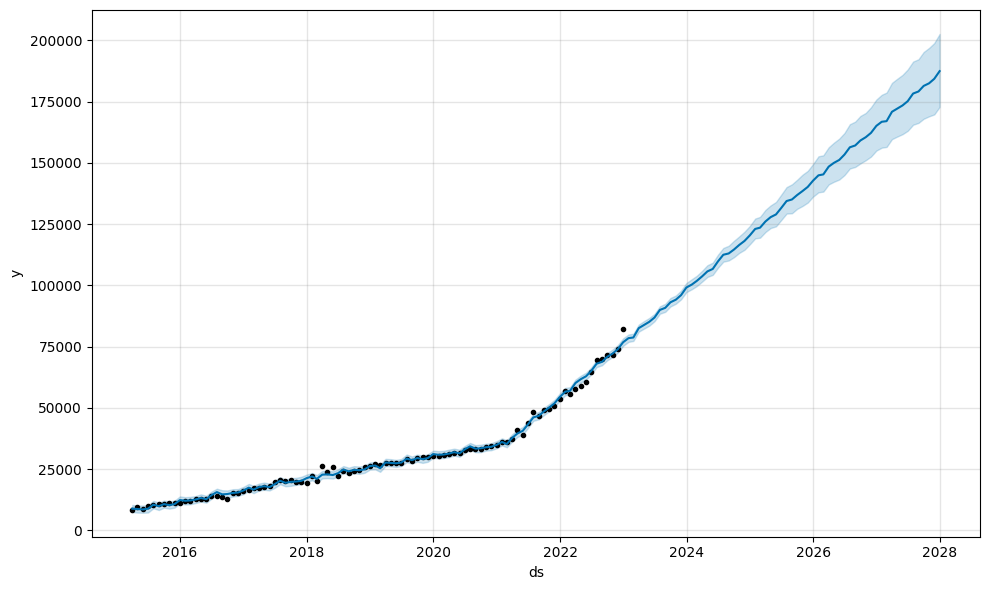

In [191]:
#Prévision du nombre de Points de charge à 5 ans
future = model.make_future_dataframe(periods=60, freq='M')
forecast = model.predict(future)
fig = model.plot(forecast)
fig.savefig('p8_img/forecast_prophet_pdc.png')

In [192]:
#Affichage des 5 derniers mois de prévision
forecast_pdc = model.predict(future)
forecast_pdc[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds           yhat     yhat_lower     yhat_upper
149 2027-08-31  179095.298048  165835.076656  192021.616418
150 2027-09-30  181359.400582  167489.047812  194633.015442
151 2027-10-31  182419.685185  168320.845338  196036.432141
152 2027-11-30  184255.404363  169889.039429  198019.278010
153 2027-12-31  187395.778562  172622.357435  201445.604647

In [193]:
#Sauvegarde 
forecast_pdc.to_csv('p8_datatable/forecast_pdc.csv')

D'ici fin 2024 le maillage de Points de charge pourrait être étendu à environ 56 000 connecteurs, selon la prédiction de l'algorithme Prophet.

In [194]:
pdc_forecast_prophet["ds"]=pdc_forecast_prophet["ds"].apply(pd.to_datetime)
forecast_pdc["ds"]=forecast_pdc["ds"].apply(pd.to_datetime)

In [195]:
#Préparation des données (observations + prévisions) pour Test statistique
metric_forecast_pdc = forecast_pdc.set_index('ds')[['yhat']].join(pdc_forecast_prophet.set_index('ds')[["y"]]).reset_index()
metric_forecast_pdc.dropna(inplace=True)
metric_forecast_pdc

ds          yhat        y
0  2015-03-31   8858.921559   8478.0
1  2015-04-30   8721.443647   9539.0
2  2015-05-31   8548.901652   8713.0
3  2015-06-30   8864.261532  10086.0
4  2015-07-31  10498.327808  10158.0
..        ...           ...      ...
89 2022-08-31  68773.252464  69963.0
90 2022-09-30  70812.196029  71630.0
91 2022-10-31  72158.020074  71645.0
92 2022-11-30  73912.625879  73874.0
93 2022-12-31  76779.608962  82107.0

[94 rows x 3 columns]

In [196]:
#Mesures statistiques permettant d'évaluer le modèle
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math 
print("R2 = " + str(r2_score(metric_forecast_pdc['y'], metric_forecast_pdc['yhat'])))
print("MSE = " + str(mean_squared_error(metric_forecast_pdc['y'], metric_forecast_pdc['yhat'])))
print("RMSE = " + str(math.sqrt(mean_squared_error(metric_forecast_pdc['y'], metric_forecast_pdc['yhat']))))
print("MAE = " + str(mean_absolute_error(metric_forecast_pdc['y'], metric_forecast_pdc['yhat'])))

R2 = 0.9955988206550742
MSE = 1334676.3535941998
RMSE = 1155.281936842345
MAE = 770.5647466962217


Les coefficients statistiques sont plus optimistes que ceux des précédentes prévisions. Le coefficient de détermination reste proche de 1, seulement les autres métriques d'écart sont assez élevées. En d'autres termes la robustesse du modèle n'est pas très satisfaisante.

<u>A des fins de comparaison, la méthode de Holt-winters est également exploitée.</u>

In [197]:
#Préparation des données
irve_forecast_hw = irve_type_month.copy()
irve_forecast_hw['time'] = pd.to_datetime(irve_forecast_hw['time'])
irve_forecast_hw.set_index('time', inplace=True)

In [198]:
#Méthode ExponentialSmoothing de statsmodels est utilisée pour la modélisation d'Holt-Winters.


y = np.array(irve_forecast_hw['Accessible au public'])
hw = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(60)

/home/mattia/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



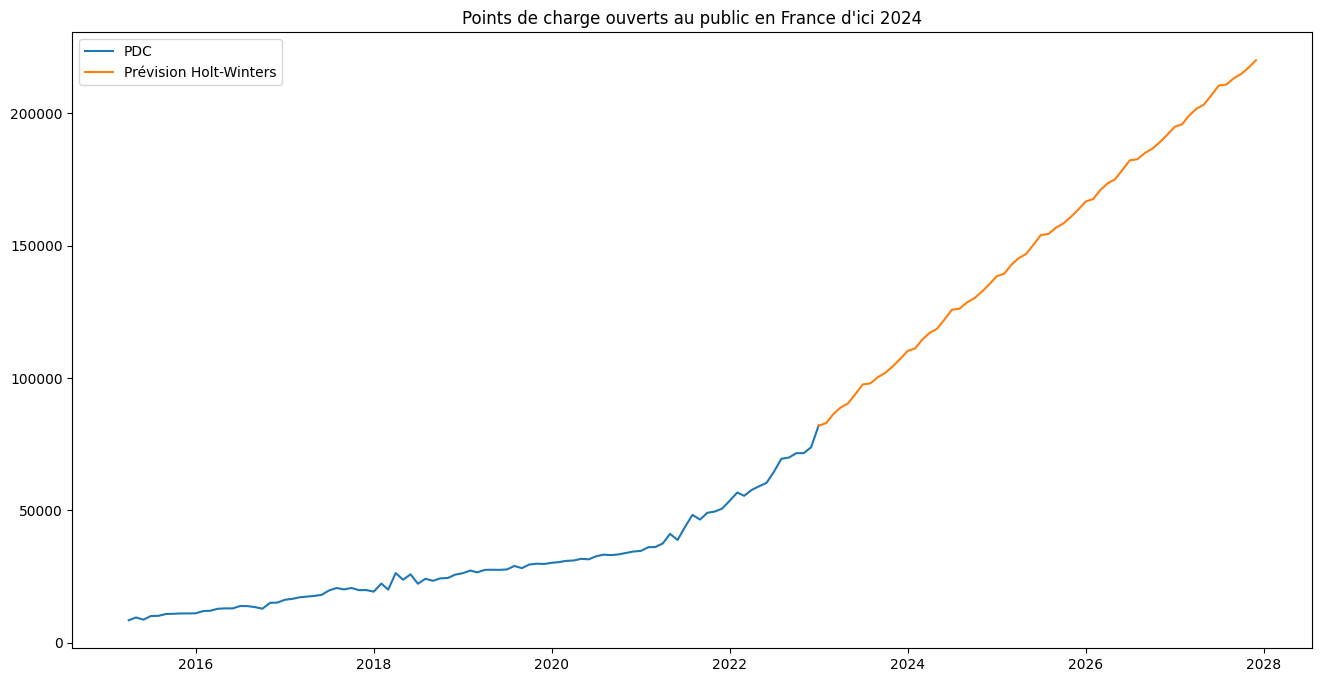

In [199]:
#Visualisation de la prévision à 5 ans par Holt-Winters
plt.figure(figsize(16, 8))
plt.plot(irve_forecast_hw['Accessible au public'], label='PDC')
plt.plot(pd.date_range(irve_forecast_hw.index[len(y)-1], periods=60, freq='M'), 
         hw_pred, label='Prévision Holt-Winters')

plt.title("Points de charge ouverts au public en France d'ici 2024")

fig.savefig('p8_img/holtwinters_pdc.png')
plt.legend()
plt.show()

In [200]:
#Affichage des valeurs prédites
hw_pred

array([ 82014.67208712,  82993.94513997,  86272.86135844,  88877.11715493,
        90403.75958601,  93985.40939496,  97603.33063114,  98001.27891051,
       100361.05916199, 101965.71147015, 104427.13246107, 107172.38784365,
       110248.30870423, 111227.58175709, 114506.49797555, 117110.75377205,
       118637.39620312, 122219.04601208, 125836.96724826, 126234.91552763,
       128594.69577911, 130199.34808727, 132660.76907818, 135406.02446077,
       138481.94532135, 139461.2183742 , 142740.13459267, 145344.39038916,
       146871.03282024, 150452.68262919, 154070.60386537, 154468.55214474,
       156828.33239622, 158432.98470438, 160894.4056953 , 163639.66107788,
       166715.58193846, 167694.85499132, 170973.77120978, 173578.02700628,
       175104.66943736, 178686.31924631, 182304.24048249, 182702.18876186,
       185061.96901334, 186666.6213215 , 189128.04231242, 191873.297695  ,
       194949.21855558, 195928.49160843, 199207.4078269 , 201811.66362339,
       203338.30605447, 2

**Après ces deux modélisations, on peut conclure à un développement du réseau des points de charge (PDC ou Charging Point) entre 55 000  et 60 000 connecteurs d'ici fin 2024.** 

[Retour vers la page notebook précédente (Positionnement de la voiture électrique de 2010 à 2019 et prévision à 2 ans)](https://github.com/nalron/project_electric_cars_france2040/blob/french_version/p8_notebook01.ipynb)

[Voir la suite du projet : Appel de charge au réseau électrique (Profilage d'un pic de consommation en 2040, etc…)](https://github.com/nalron/project_electric_cars_france2040/blob/french_version/p8_notebook03.ipynb)